In [180]:
import json
import urllib.request as ur

from tqdm.notebook import tqdm as tq

import xarray as xr
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

_np = np.seterr(all="ignore", divide="raise")

In [2]:
def gompertz_func(x, a, b, k, e):
    exp = - np.exp(k * (b - x))    
    return a * np.exp(exp) + e

In [3]:
def double_gompertz(x, a1, b1, k1, a2, b2, k2, e):
    exp1 = - np.exp(k1 * (b1 - x))
    g1 = a1 * np.exp(exp1)
    exp2 = - np.exp(k2 * (b2 - x))
    g2 = (a2 - a1) * np.exp(exp2)
    return g1 + g2 + e

In [4]:
def logistic_func(x, a, b, k, e):
    d = k * (b - np.array(x))
    return (a / (1 + np.exp(d))) + e

In [5]:
def double_logistic(x, a1, b1, k1, a2, b2, k2, e):
    d1 = k1 * (b1 - np.array(x))
    l1 = a1 / (1 + np.exp(d1))
    d2 = k2 * (b2 - np.array(x))
    l2 = (a2 - a1) / (1 + np.exp(d2))
    return l1 + l2 + e

In [6]:
def logit(cases):
    popt, pcov = None, None
    
    new_cases = pd.Series(cases).diff()
    max_new_cases = new_cases.argmax()

    p0=[
        cases[max_new_cases], max_new_cases, 1,
        cases[0]
    ]
    popt, pcov = curve_fit(
        logistic_func,
        [i for i in range(len(cases))],
        cases,
        p0=p0, maxfev=8000, method="trf"
    )
    results = logistic_func([i for i in range(len(cases))], *popt)
    
    return results

In [7]:
def gomp(cases):
    popt, pcov = None, None
    
    new_cases = pd.Series(cases).diff()
    max_new_cases = new_cases.argmax()

    p0=[
        cases[max_new_cases] * 2, max_new_cases, 1,
        cases[0]
    ]
    popt, pcov = curve_fit(
        gompertz_func,
        [i for i in range(len(cases))],
        cases,
        p0=p0, maxfev=8000, method="trf"
    )
    results = gompertz_func([i for i in range(len(cases))], *popt)
    
    return results

In [8]:
def dobgomp(cases):
    popt, pcov = None, None
    
    new_cases = pd.Series(cases).diff()
    max_new_cases = new_cases.argmax()

    p0=[
        cases[max_new_cases] * 2, max_new_cases, 1,
        max(cases), len(cases), 1,
        cases[0]
    ]
    popt, pcov = curve_fit(
        double_gompertz,
        [i for i in range(len(cases))],
        cases,
        p0=p0, maxfev=8000, method="trf"
    )
    results = double_gompertz([i for i in range(len(cases))], *popt)

    return results

In [9]:
def doblogit(cases):
    popt, pcov = None, None
    
    new_cases = pd.Series(cases).diff()
    max_new_cases = new_cases.argmax()
    
    p0=[
        cases[max_new_cases], max_new_cases, 1,
        max(cases), len(cases), 1,
        cases[0]
    ]
    popt, pcov = curve_fit(
        double_logistic,
        [i for i in range(len(cases))],
        cases,
        p0=p0, maxfev=8000, method="trf"
    )
    results = double_logistic([i for i in range(len(cases))], *popt)
    
    return results

In [10]:
url = 'https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/json/COVID-COUNTRIES.json'
with ur.urlopen(url) as _url:
    _data = json.loads(_url.read().decode())

In [11]:
# create empty 3d array

F = ["measured", "Logit", "DobLogit", "Gomp", "DobGomp"]
C = list(_data.keys())
D = pd.to_datetime(list(_data["China"]["Confirmed"].keys()))

null_arr = [
    [
        [
            None for _ in range(len(D))
        ] for _ in range(len(C))
    ] for _ in range(len(F))
]

_a = null_arr

In [12]:
# load measured data in array x

for _c, c in enumerate(tq(sorted(_data))):
    for _d, d in enumerate(_data[c]["Confirmed"]):
        _a[0][_c][_d] = _data[c]["Confirmed"][d]

In [13]:
# interpolate on logit

for _c, c in enumerate(tq(sorted(_data))):
    try:
        interp = logit(list(_data[c]["Confirmed"].values()))
        _a[1][_c] = interp
    except Exception as err:
        print(f"{c} -> {err}")

In [14]:
# interpolate on doblogit

for _c, c in enumerate(tq(sorted(_data))):
    try:
        interp = doblogit(list(_data[c]["Confirmed"].values()))
        _a[2][_c] = interp
    except Exception as err:
        print(f"{c} -> {err}")

Burundi -> Optimal parameters not found: The maximum number of function evaluations is exceeded.
Cabo Verde -> Optimal parameters not found: The maximum number of function evaluations is exceeded.
Central African Republic -> Optimal parameters not found: The maximum number of function evaluations is exceeded.
Cyprus -> Optimal parameters not found: The maximum number of function evaluations is exceeded.
Suriname -> Optimal parameters not found: The maximum number of function evaluations is exceeded.



In [15]:
# interpolate on gomp

for _c, c in enumerate(tq(sorted(_data))):
    try:
        interp = gomp(list(_data[c]["Confirmed"].values()))
        _a[3][_c] = interp
    except Exception as err:
        print(f"{c} -> {err}")

Ecuador -> Optimal parameters not found: The maximum number of function evaluations is exceeded.
Equatorial Guinea -> divide by zero encountered in true_divide
Eswatini -> divide by zero encountered in true_divide
Jamaica -> Optimal parameters not found: The maximum number of function evaluations is exceeded.
Maldives -> divide by zero encountered in true_divide
Mozambique -> Optimal parameters not found: The maximum number of function evaluations is exceeded.
Nigeria -> Optimal parameters not found: The maximum number of function evaluations is exceeded.
Qatar -> Optimal parameters not found: The maximum number of function evaluations is exceeded.



In [16]:
# interpolate on dobgomp

for _c, c in enumerate(tq(sorted(_data))):
    try:
        interp = dobgomp(list(_data[c]["Confirmed"].values()))
        _a[4][_c] = interp
    except Exception as err:
        print(f"{c} -> {err}")

Bhutan -> Optimal parameters not found: The maximum number of function evaluations is exceeded.
Congo (Brazzaville) -> Optimal parameters not found: The maximum number of function evaluations is exceeded.
Japan -> Optimal parameters not found: The maximum number of function evaluations is exceeded.
Liechtenstein -> Optimal parameters not found: The maximum number of function evaluations is exceeded.
Montenegro -> Optimal parameters not found: The maximum number of function evaluations is exceeded.
Trinidad and Tobago -> Optimal parameters not found: The maximum number of function evaluations is exceeded.



In [18]:
a = xr.DataArray(_a, coords=[F, C, D], dims=["function", "country", "date"])

In [19]:
a

<xarray.DataArray (function: 5, country: 185, date: 96)>
array([[[0, 0, 0, ..., 1351, 1463, 1531],
        [0, 0, 0, ..., 678, 712, 726],
        [0, 0, 0, ..., 3127, 3256, 3382],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 84, 84, 88],
        [0, 0, 0, ..., 29, 31, 31]],

       [[-8.043849045091337, -8.031228756678493, -8.017138966410466,
         ..., 1352.7317439064345, 1419.1941304901297,
         1484.4876227899513],
        [-8.23553941156504, -8.20521100176875, -8.171598148874201, ...,
         659.0255512532627, 670.0648961860189, 680.3428058815665],
        [-22.578020459931935, -22.55634815802643, -22.531777082183684,
         ..., 3076.577128302909, 3137.1665569411966, 3192.607966362355],
        ...,
        [-1.548888717669126e-19, -1.548888717669126e-19,
         -1.548888717669126e-19, ..., 1.0, 1.0, 1.0],
        [-1.7249474875885888, -1.716752463230984, -1.7078397666146785,
         ..., 76.87594954569491, 79.07835809385311, 81.21476736905953],
        [-0.20122130170722785, -0.20079928523469362,
         -0.20032795127338665, ..., 29.825729131000802,
         30.749558320353636, 31.626300201385018]],

       [[-8.043968233067062, -8.031347756672858, -8.017257759610402,
         ..., 1352.7317621225948, 1419.1942620417262,
         1484.4878902394644],
        [-8.235526679759317, -8.205198215022051, -8.171585302533373,
         ..., 659.0256488818449, 670.0650080736312, 680.3429318217582],
        [3.456223124137942, 3.4562965356779625, 3.456387233034815, ...,
         3150.4728784885324, 3254.251157938557, 3352.1864144154542],
        ...,
        [8.88312906028616e-19, 8.88312906028616e-19,
         8.88312906028616e-19, ..., 1.0, 1.0, 1.0],
        [0.0661796393978661, 0.06617963941662564, 0.06617963944219839,
         ..., 81.82303733581166, 85.03852989897115, 87.71681879810532],
        [-0.27485540470215636, -0.2742595430014671,
         -0.27359675698965796, ..., 29.21205187227553,
         29.812630345533915, 30.377915825464147]],

       [[-1.475189358860102, -1.4751893588071006, -1.4751893586639055,
         ..., 1351.4870662086942, 1425.4571505598033,
         1500.9495197685874],
        [-1.7336858547498124, -1.7336858547498035, -1.7336858547497485,
         ..., 666.091585446216, 680.9831807804145, 695.4846727020324],
        [-0.3817274667848485, -0.3817274667848485, -0.3817274667848485,
         ..., 3102.49818991684, 3184.1481163036206, 3263.0815852296496],
        ...,
        [3.0944351086756547e-19, 3.0944351086756547e-19,
         3.0944351086756547e-19, ..., 1.0, 1.0, 1.0],
        [-0.6641031500146619, -0.6641031499932587, -0.6641031499258884,
         ..., 75.81960823109469, 77.94993222967437, 80.05098289056446],
        [-0.06975898821518403, -0.06975898821515264,
         -0.06975898821503515, ..., 29.946851973354264,
         31.10544816803563, 32.262193909737746]],

       [[-1.4750240322780237, -1.4750240322250585, -1.475024032081956,
         ..., 1351.4864897733632, 1425.4562102005846,
         1500.9481593711014],
        [-1.7336320822530285, -1.7336320822530196, -1.7336320822529645,
         ..., 666.0916879216036, 680.9832892530274, 695.4847866286477],
        [7.66936369185645, 7.66936369185645, 7.66936369185645, ...,
         3148.462523340274, 3253.104928494604, 3353.080539340622],
        ...,
        [-3.74862929882215e-18, -3.74862929882215e-18,
         -3.74862929882215e-18, ..., 0.999999999999907,
         0.999999999999907, 0.999999999999907],
        [0.16792058819978864, 0.16792058819978864, 0.16792058819978864,
         ..., 81.38575285824032, 85.06998033646283, 88.50721903818925],
        [0.01901136869964322, 0.01901136869964322, 0.01901136869964322,
         ..., 29.895813879138398, 30.734106049886798,
         31.521953147441323]]], dtype=object)
Coordinates:
  * function  (function) <U8 'measured' 'Logit' 'DobLogit' 'Gomp' 'DobGomp'
  * country   (country) <U32 'Afghanistan' 'Albania' ... 'Zambia' 'Zimbabwe'
  * date      (date) d

In [20]:
a.to_netcdf("data.nc")

In [225]:
def plot_country(country):
    
    plt.figure(figsize=(18, 20))
    
    ax1 = plt.subplot(313)
    ax1.plot(
        a.sel(country=country, function="Logit")["date"].values,
        a.sel(country=country, function="Logit").values,
        label="Logistic", c="r", alpha=.5, ls=":"
    )
    ax1.plot(
        a.sel(country=country, function="DobLogit")["date"].values,
        a.sel(country=country, function="DobLogit").values,
        label="Double Logistic", c="b", alpha=.5, ls=":"
    )
    ax1.plot(
        a.sel(country=country, function="Gomp")["date"].values,
        a.sel(country=country, function="Gomp").values,
        label="Gompertz", c="g", alpha=.5, ls=":"
    )
    ax1.plot(
        a.sel(country=country, function="DobGomp")["date"].values,
        a.sel(country=country, function="DobGomp").values,
        label="Double Gompertz", c="y", alpha=.5, ls=":"
    )
    ax1.scatter(
        a.sel(country=country, function="measured")["date"].values,
        a.sel(country=country, function="measured").values,
        c="k", s=10, label="measured"
    )
    
    ax2 = plt.subplot(321)
    ax2.plot(
        a.sel(country=country, function="Logit")["date"].values,
        a.sel(country=country, function="Logit").values,
        label="Logistic", c="r"
    )
    ax2.scatter(
        a.sel(country=country, function="measured")["date"].values,
        a.sel(country=country, function="measured").values,
        c="k", s=10, label="measured"
    )
    
    ax3 = plt.subplot(322)
    ax3.plot(
        a.sel(country=country, function="DobLogit")["date"].values,
        a.sel(country=country, function="DobLogit").values,
        label="Double Logistic", c="b"
    )
    ax3.scatter(
        a.sel(country=country, function="measured")["date"].values,
        a.sel(country=country, function="measured").values,
        c="k", s=10, label="measured"
    )
    
    ax4 = plt.subplot(323)
    ax4.plot(
        a.sel(country=country, function="Gomp")["date"].values,
        a.sel(country=country, function="Gomp").values,
        label="Gompertz", c="g"
    )
    ax4.scatter(
        a.sel(country=country, function="measured")["date"].values,
        a.sel(country=country, function="measured").values,
        c="k", s=10, label="measured"
    )
    
    ax5 = plt.subplot(324)
    ax5.plot(
        a.sel(country=country, function="DobGomp")["date"].values,
        a.sel(country=country, function="DobGomp").values,
        label="Double Gompertz", c="y"
    )
    ax5.scatter(
        a.sel(country=country, function="measured")["date"].values,
        a.sel(country=country, function="measured").values,
        c="k", s=10, label="measured"
    )
    
    ax1.legend(loc=2)
    ax2.legend(loc=2)
    ax3.legend(loc=2)
    ax4.legend(loc=2)
    ax5.legend(loc=2)
    
    plt.suptitle(country, fontsize=30)
    plt.show()
    plt.close(fig="all")

In [ ]:
plot_country("Andorra")

In [165]:
# create empty 3d array

C = list(_data.keys())
D = pd.to_datetime(list(_data["China"]["Confirmed"].keys())[1:])

null_arr = [
    [] for _ in range(len(C))
]

_deltas = null_arr

for _c, c in enumerate(tq(sorted(_data))):
    y = list(_data[c]["Confirmed"].values())
    dy = pd.Series(y).diff()
    _deltas[_c] = dy[1:]

deltas = xr.DataArray(_deltas, coords=[C, D], dims=["country", "date"])

In [227]:
def plot_deltas():
    OKs = []
    
    mLoc = mdates.MonthLocator()
    dLoc = mdates.DayLocator()
    mFmt = mdates.DateFormatter("%b")
    
    nrows = int(np.ceil(len(C) / 5))
    
    fig, axs = plt.subplots(ncols=5, nrows=nrows, figsize=(15, 5 * nrows))
    
    for _c, c in enumerate(deltas["country"].values):
        max_cases = max(a.sel(function="measured", country=c).values)
        max_new_cases = max(deltas.sel(country=c).values)
        last_new_cases = np.mean(deltas.sel(country=c).values[-3:-1])
        ls = ":"
        color = "y"
        lw = 1
        if max_cases > 2500:
            color = "b"
        if last_new_cases < (max_new_cases / 2):
            ls = "-"
        if (
            max_cases > 2500 and 
            last_new_cases < (max_new_cases / 2) and 
            max_new_cases not in deltas.sel(country=c).values[-3:-1]
        ):
            color = "r"
            ls = "-"
            lw = 2
            OKs.append(c)
        axs.flat[_c].plot(
            deltas["date"].values,
            deltas.sel(country=c),
            c=color, ls=ls, lw=lw
        )
        axs.flat[_c].set_title(c)
        axs.flat[_c].xaxis.set_major_locator(mLoc)
        axs.flat[_c].xaxis.set_major_formatter(mFmt)
        axs.flat[_c].xaxis.set_minor_locator(dLoc)
        axs.flat[_c].tick_params(axis="y", labelsize=7)
    return OKs

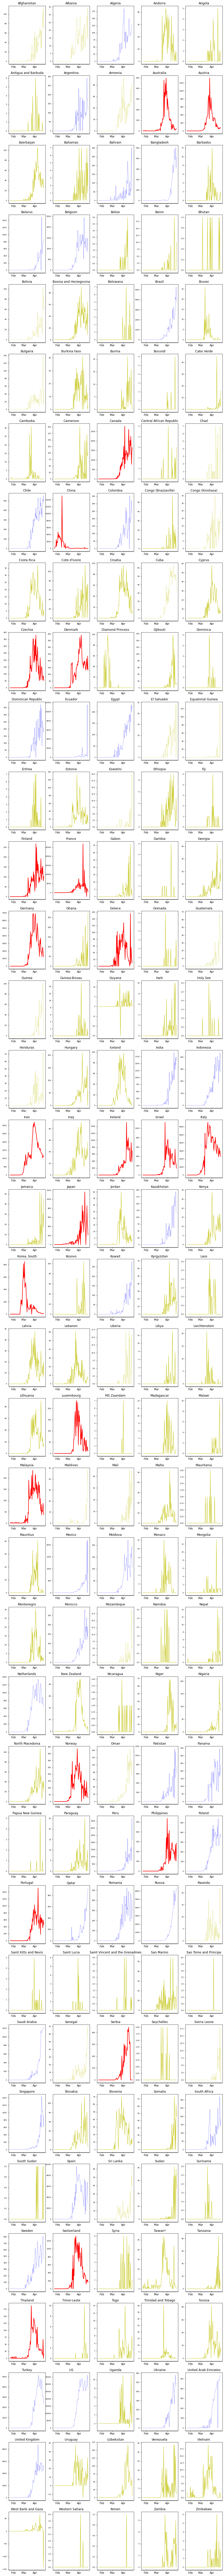

In [228]:
OKs = plot_deltas()

In [230]:
len(OKs)

24

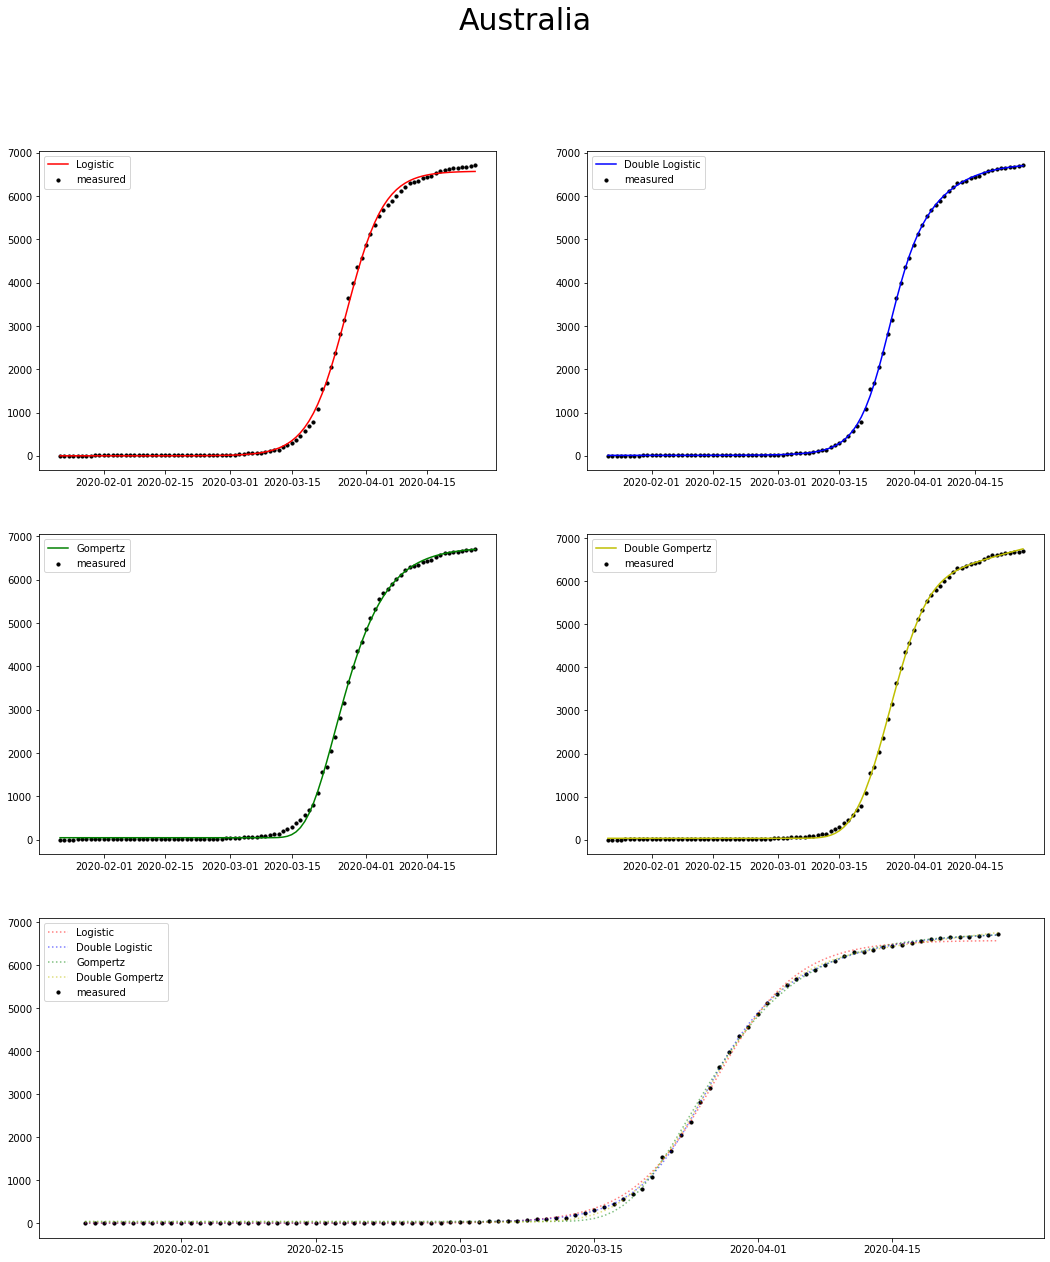

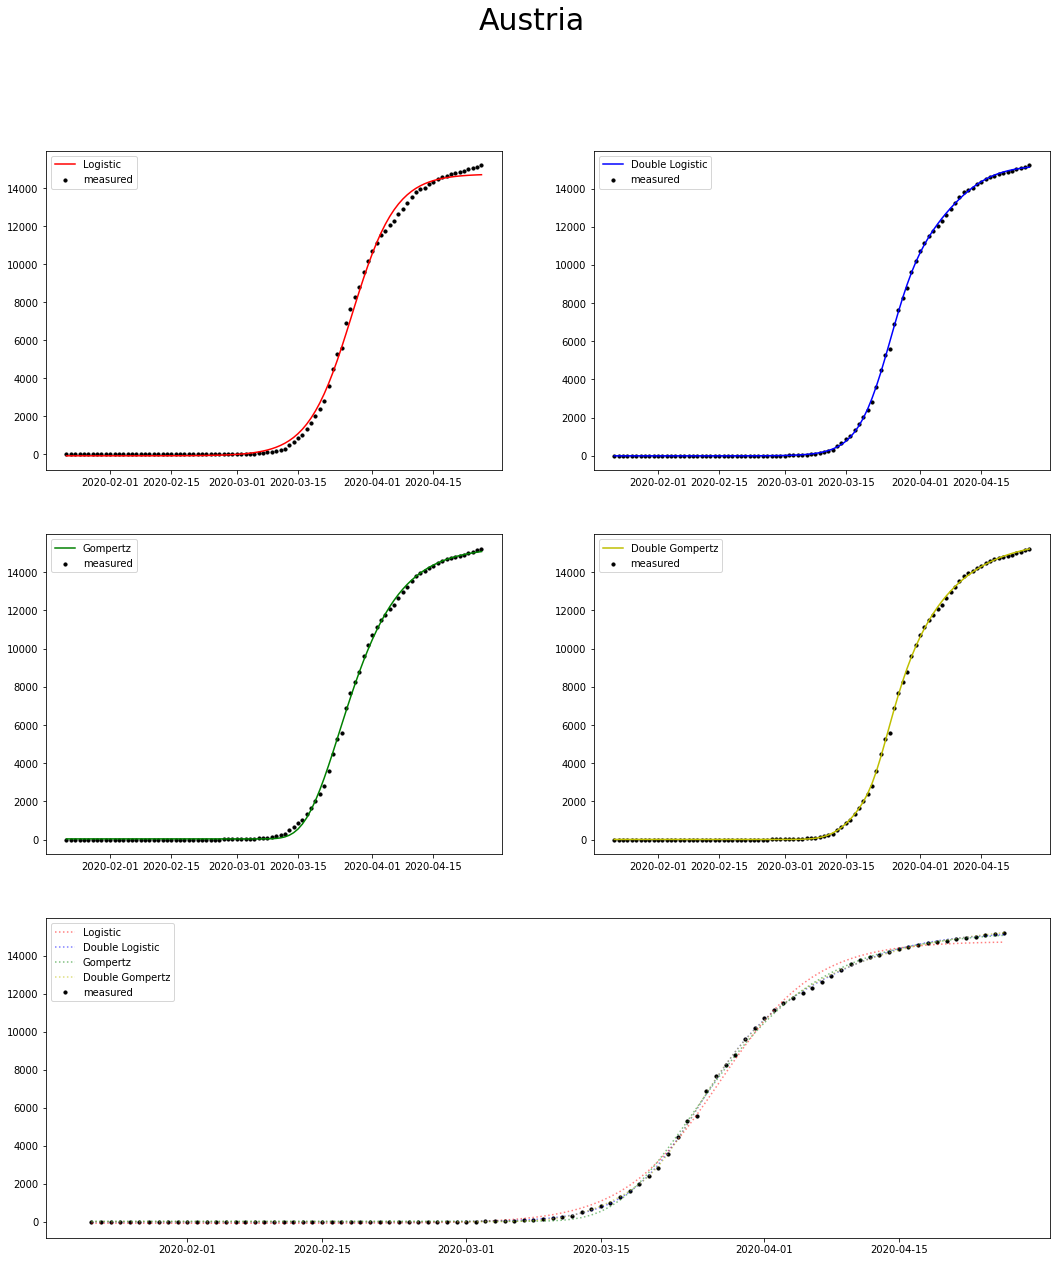

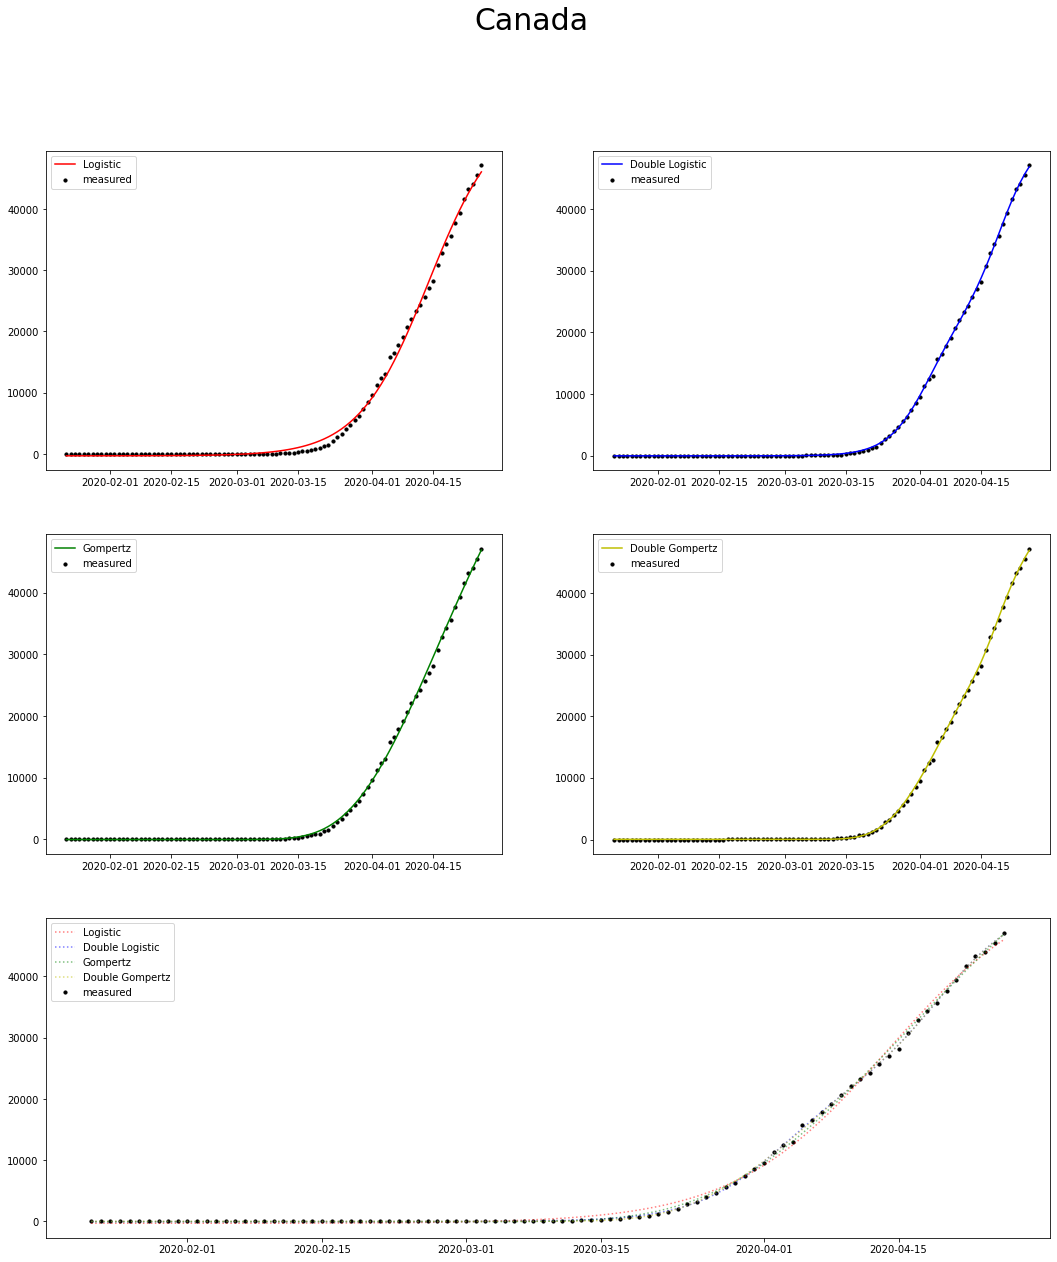

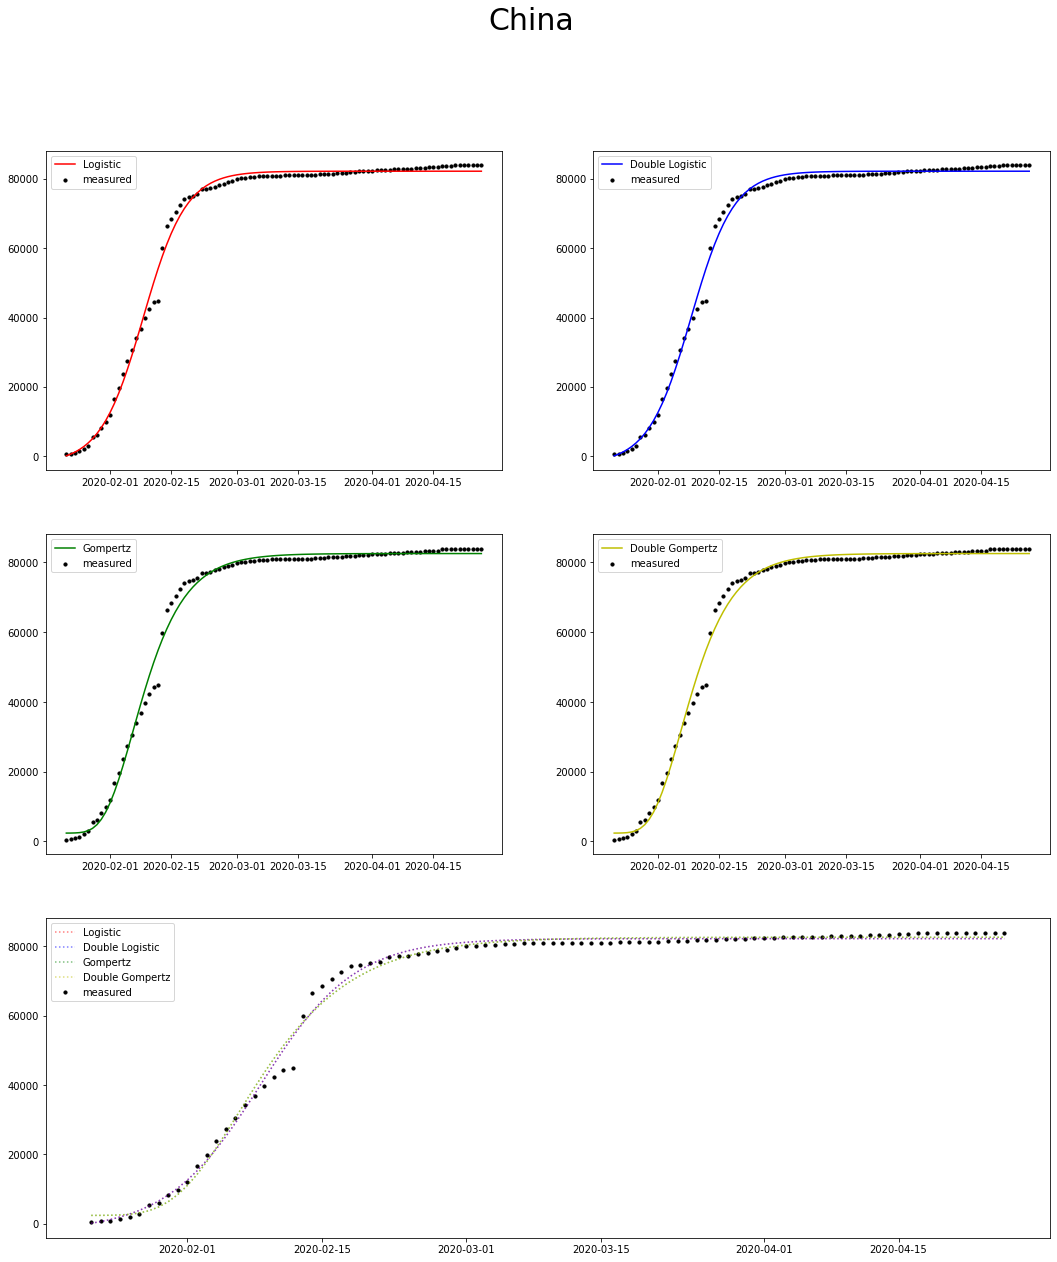

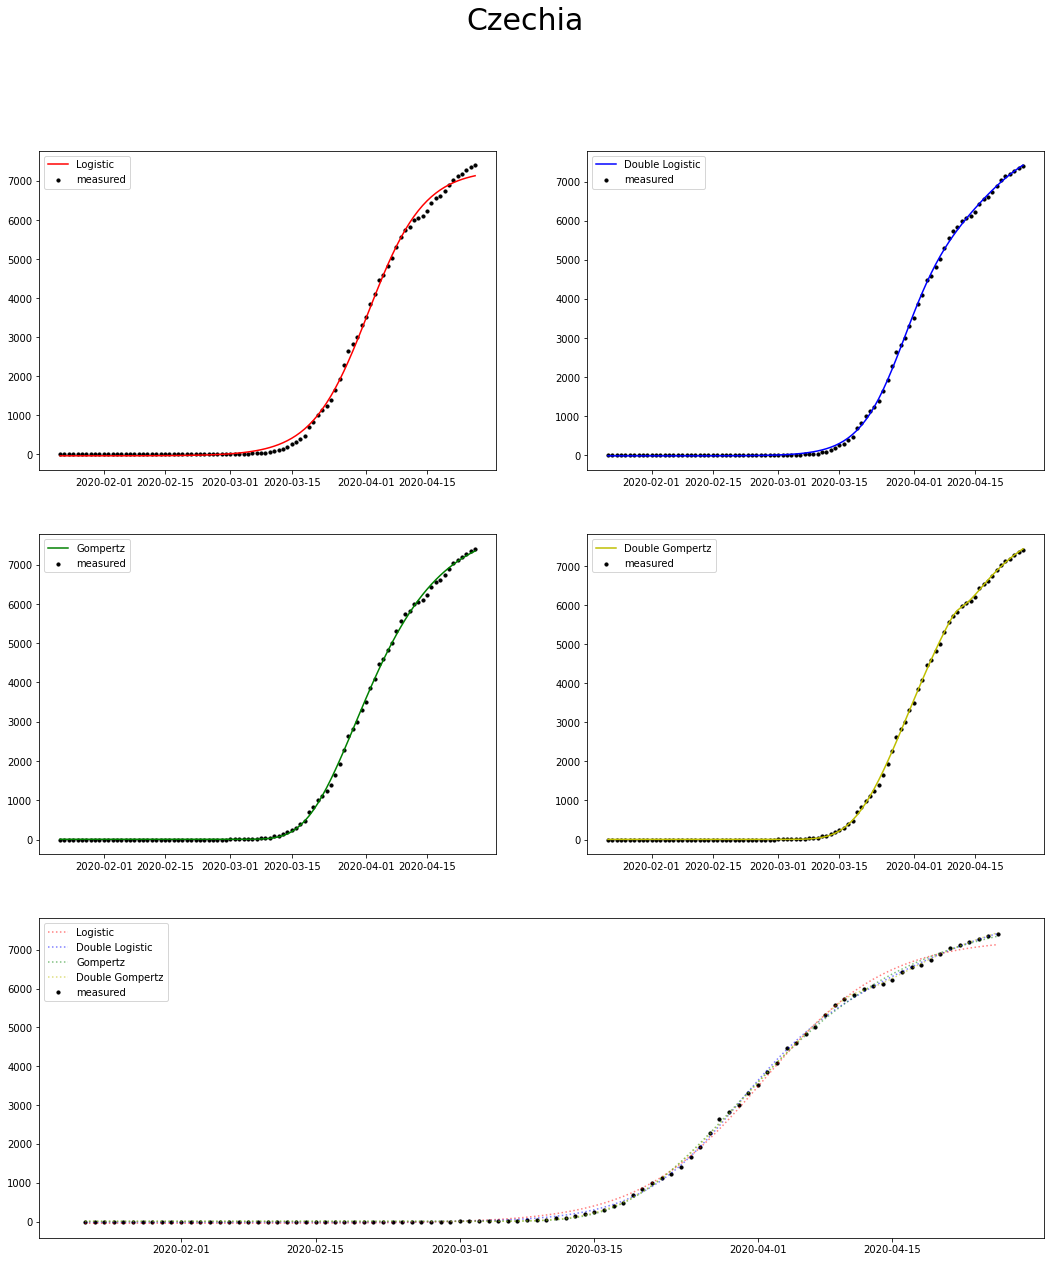

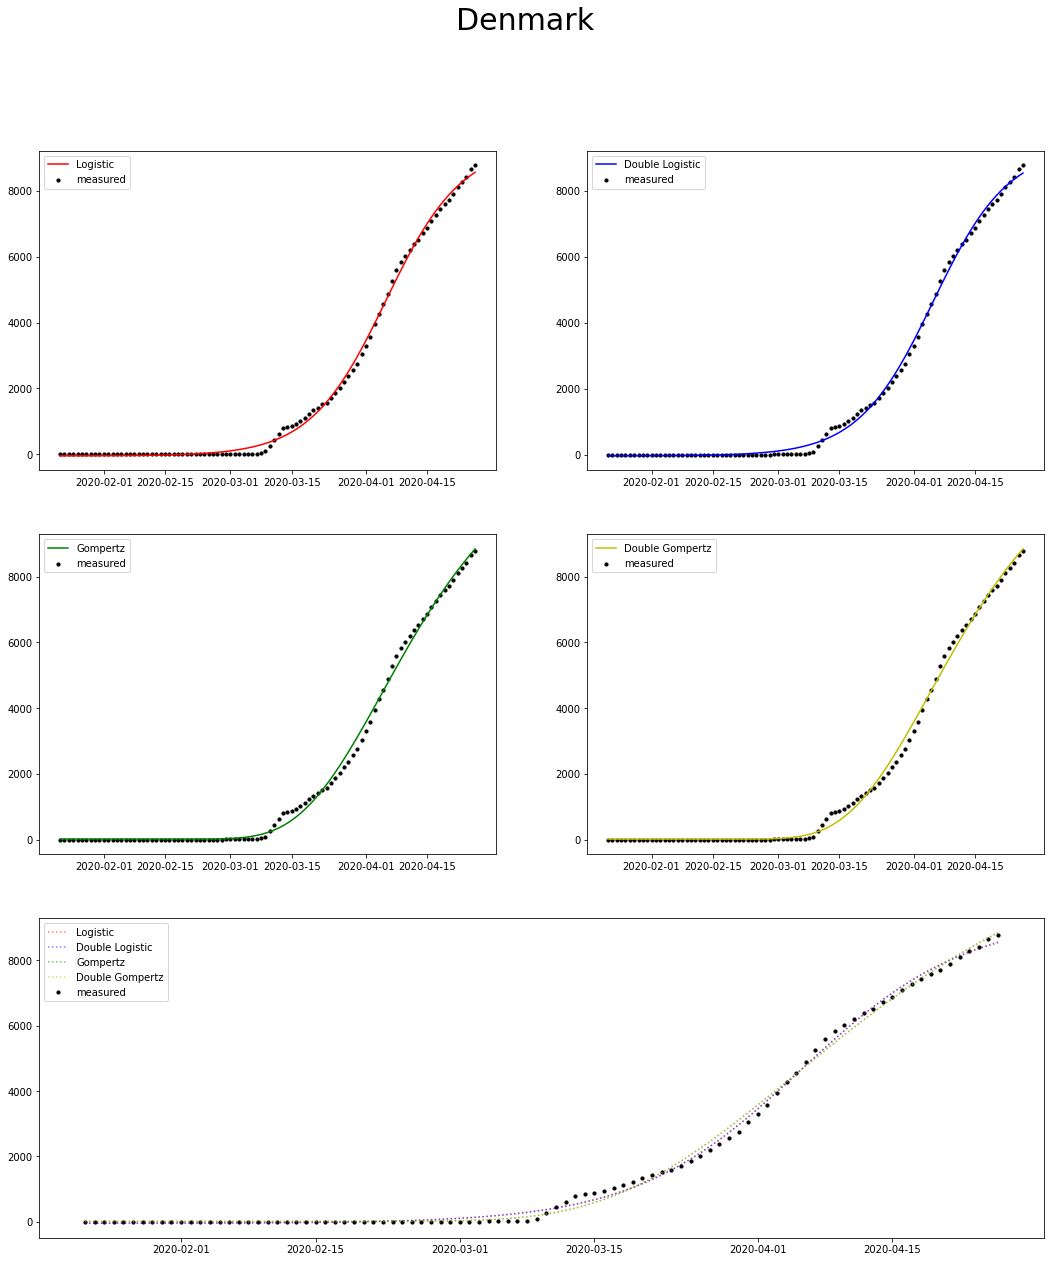

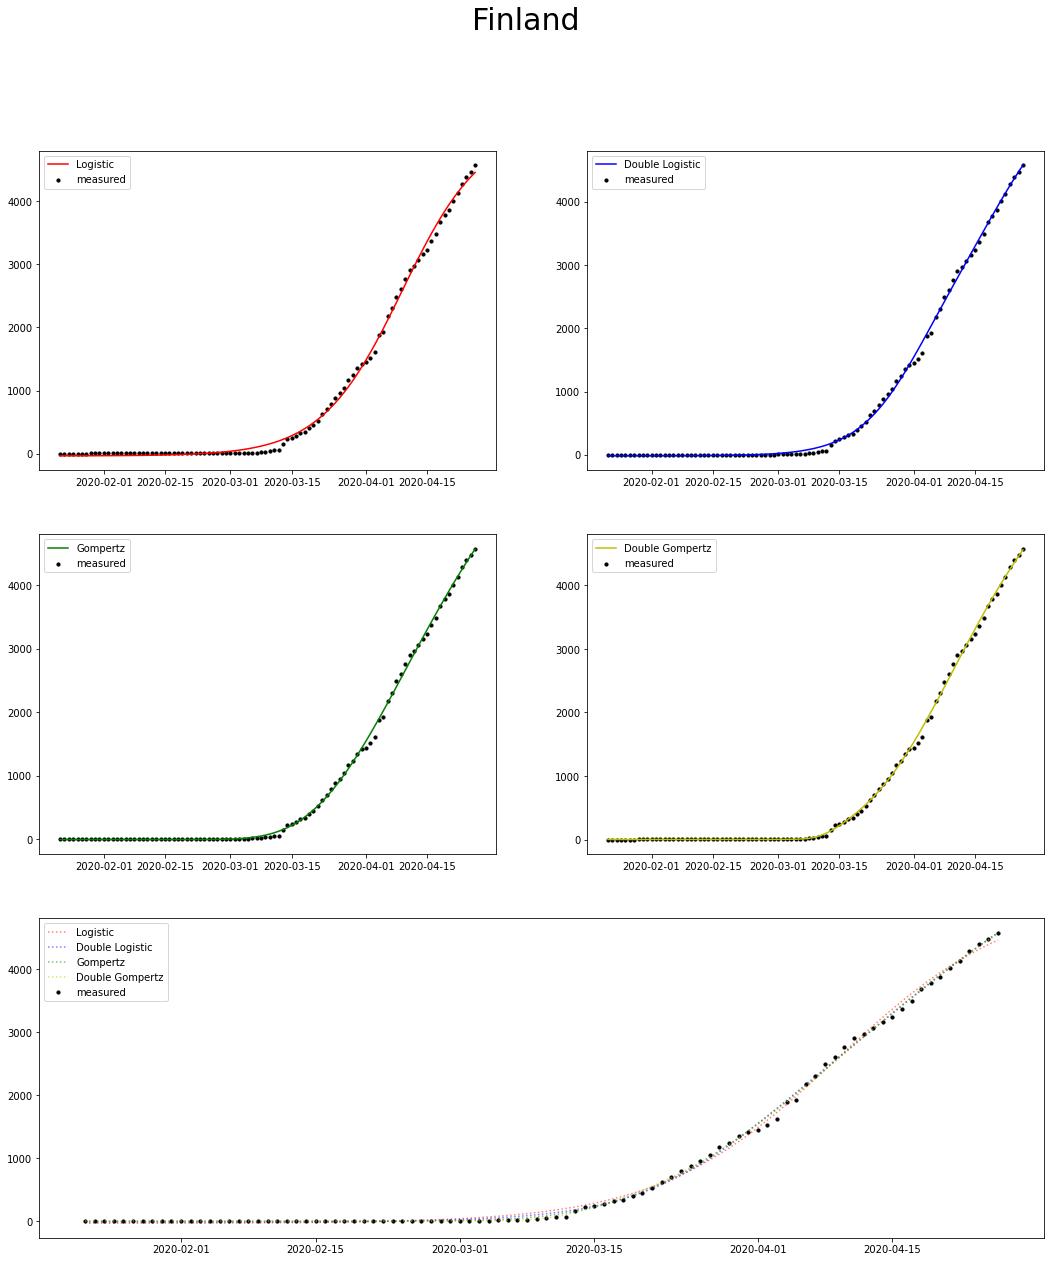

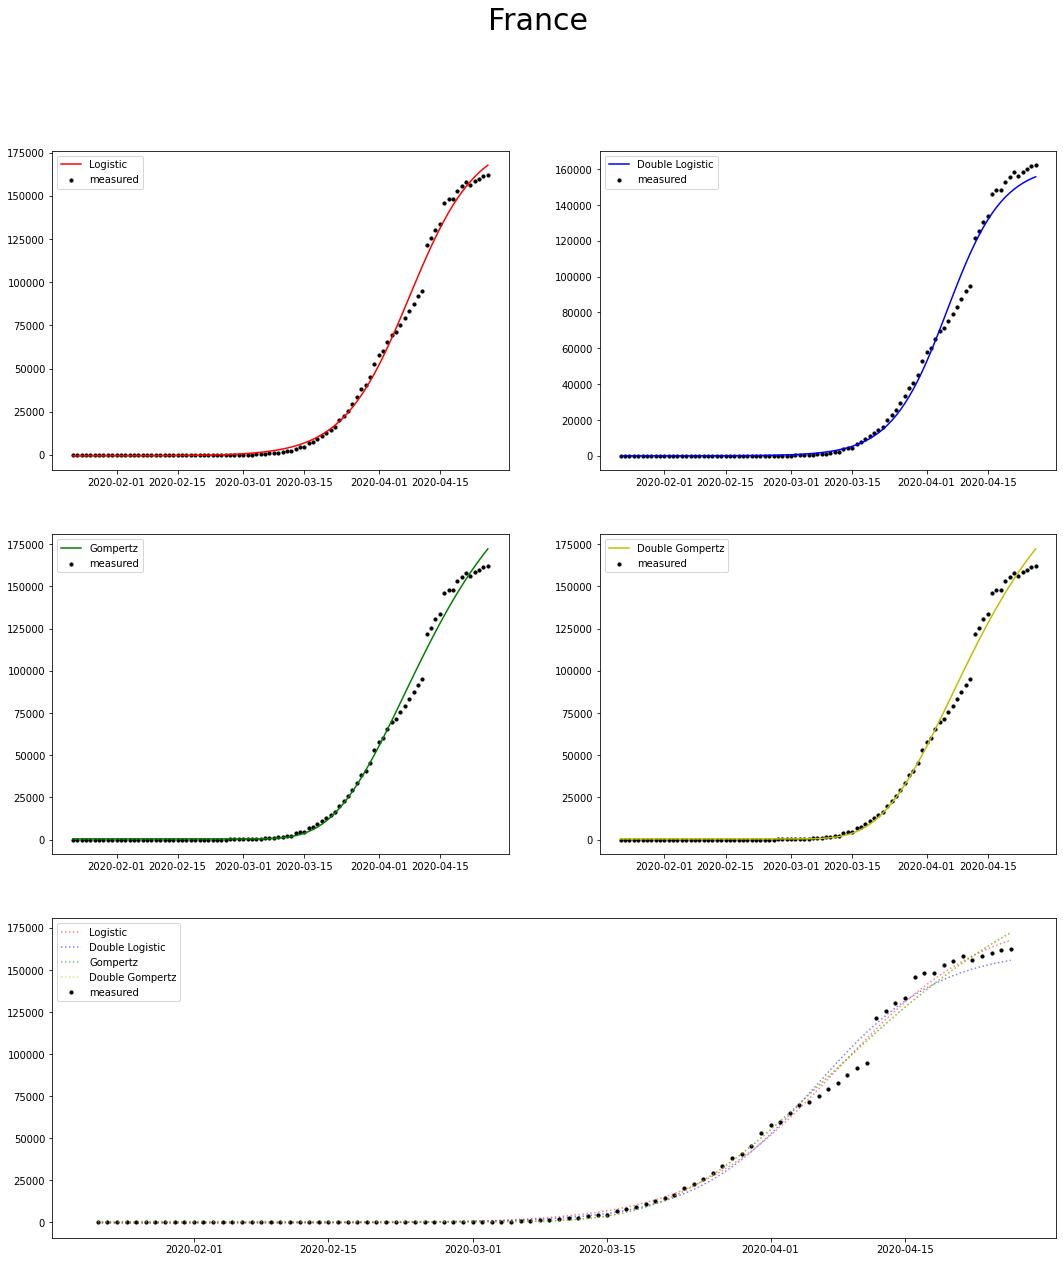

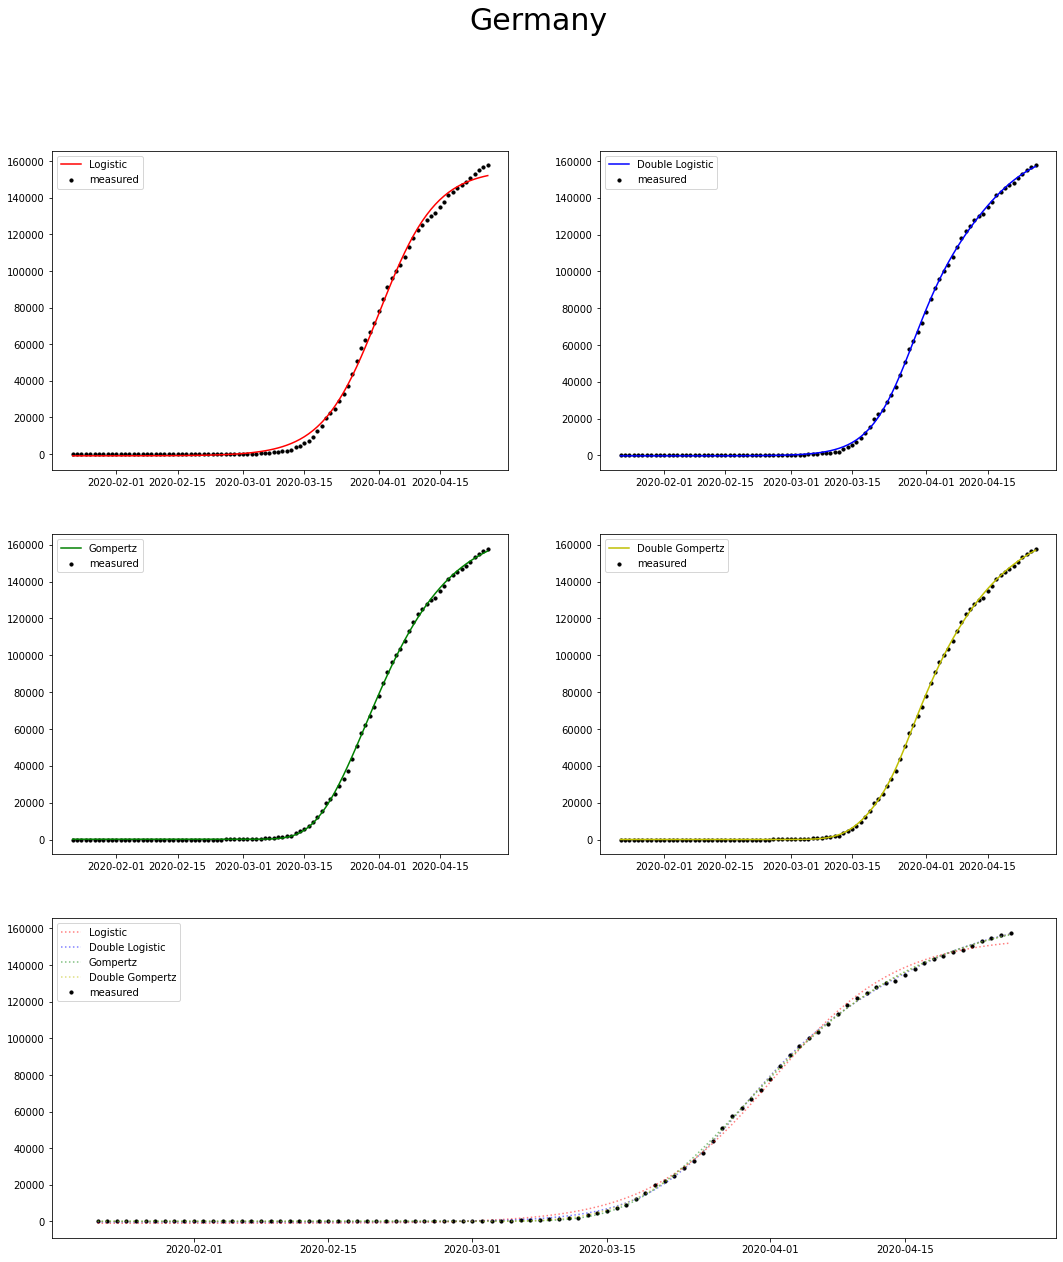

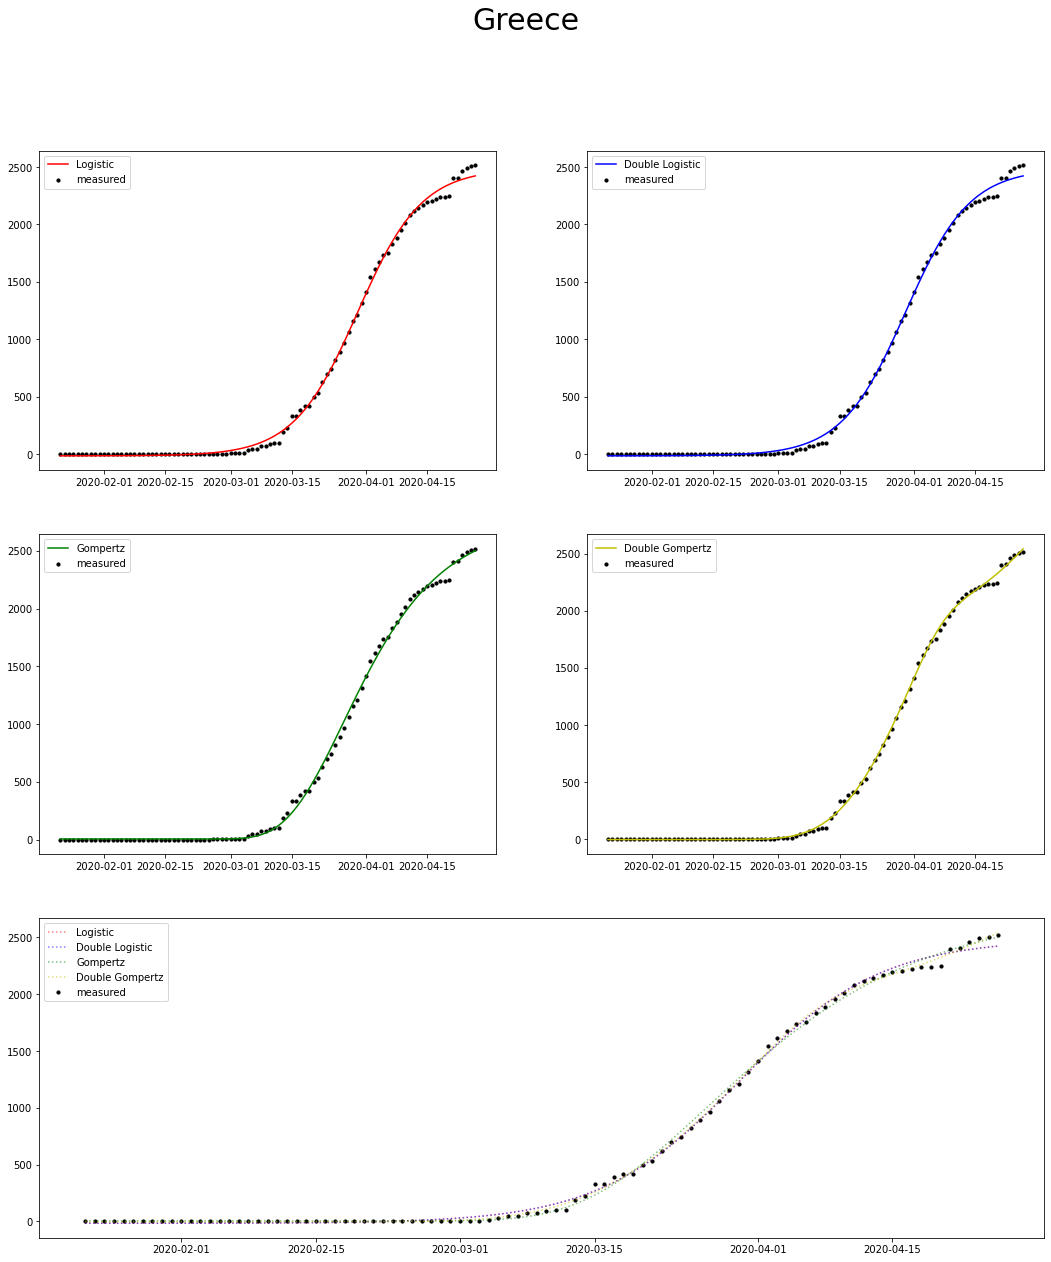

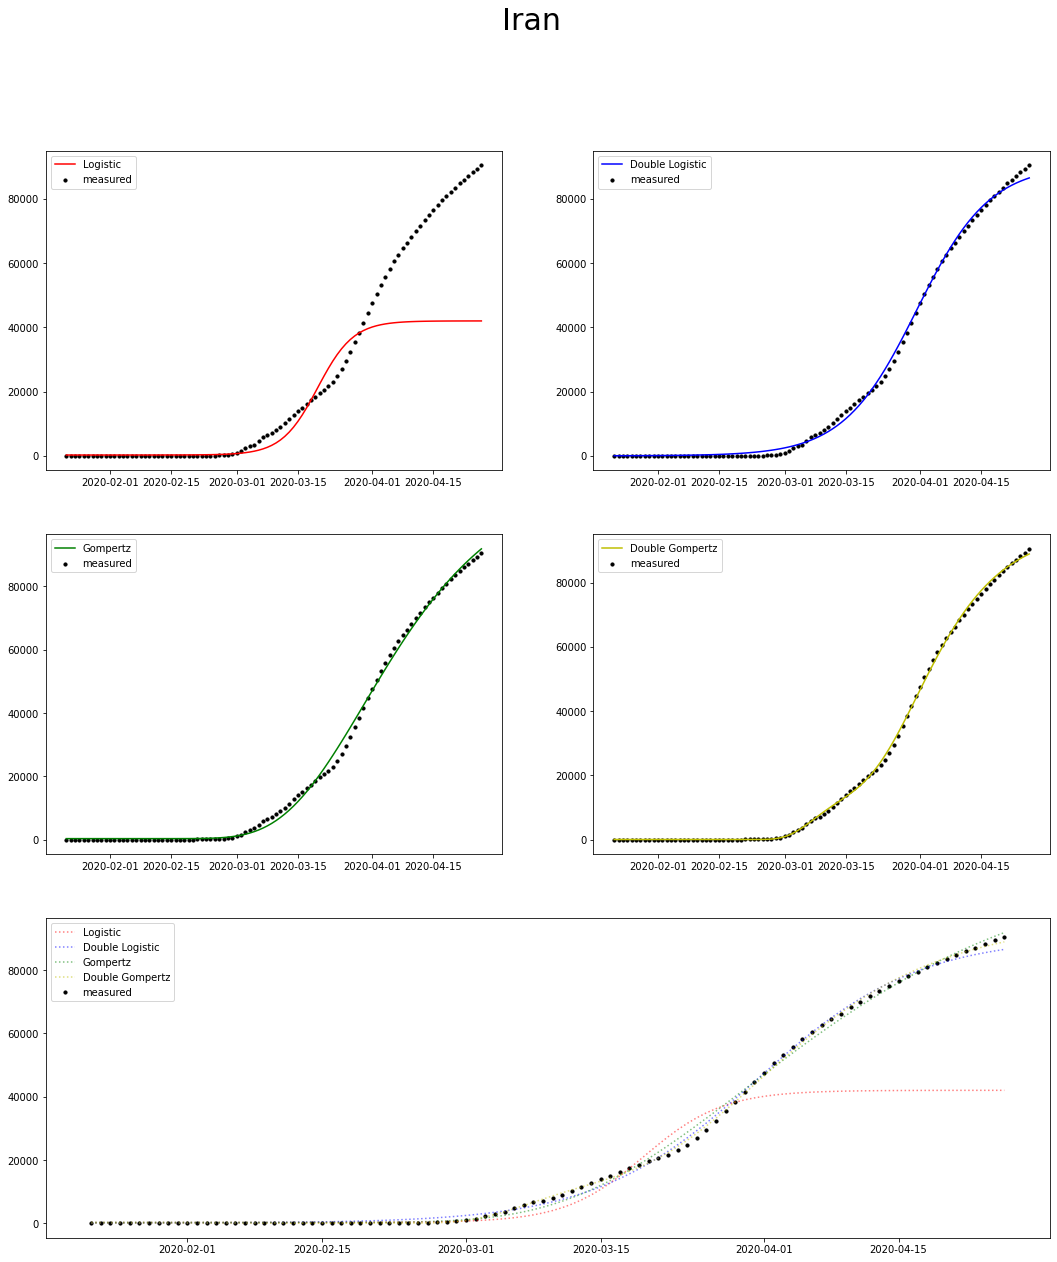

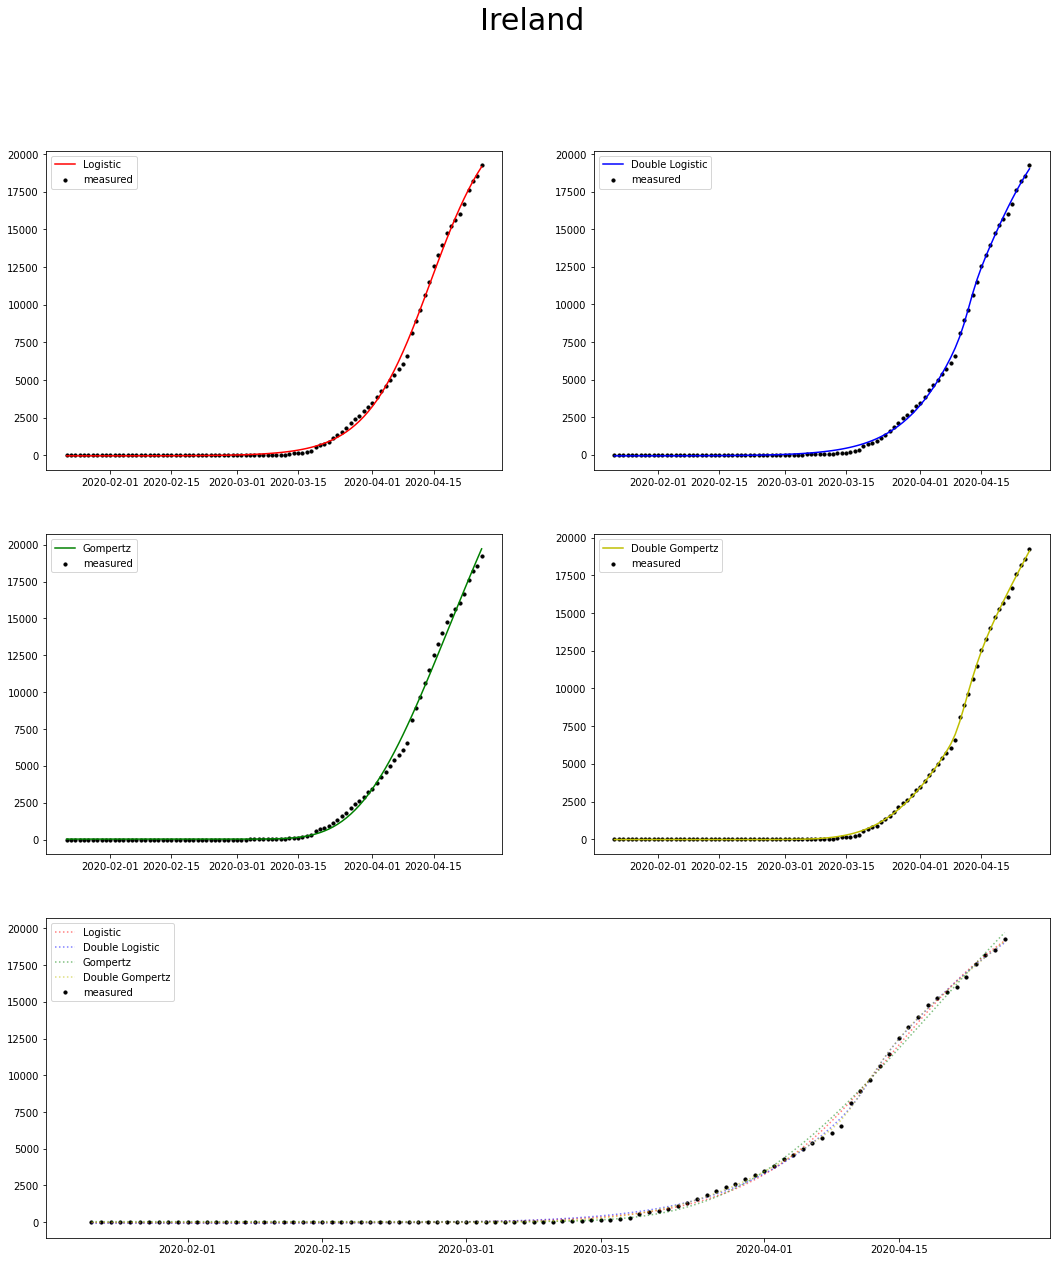

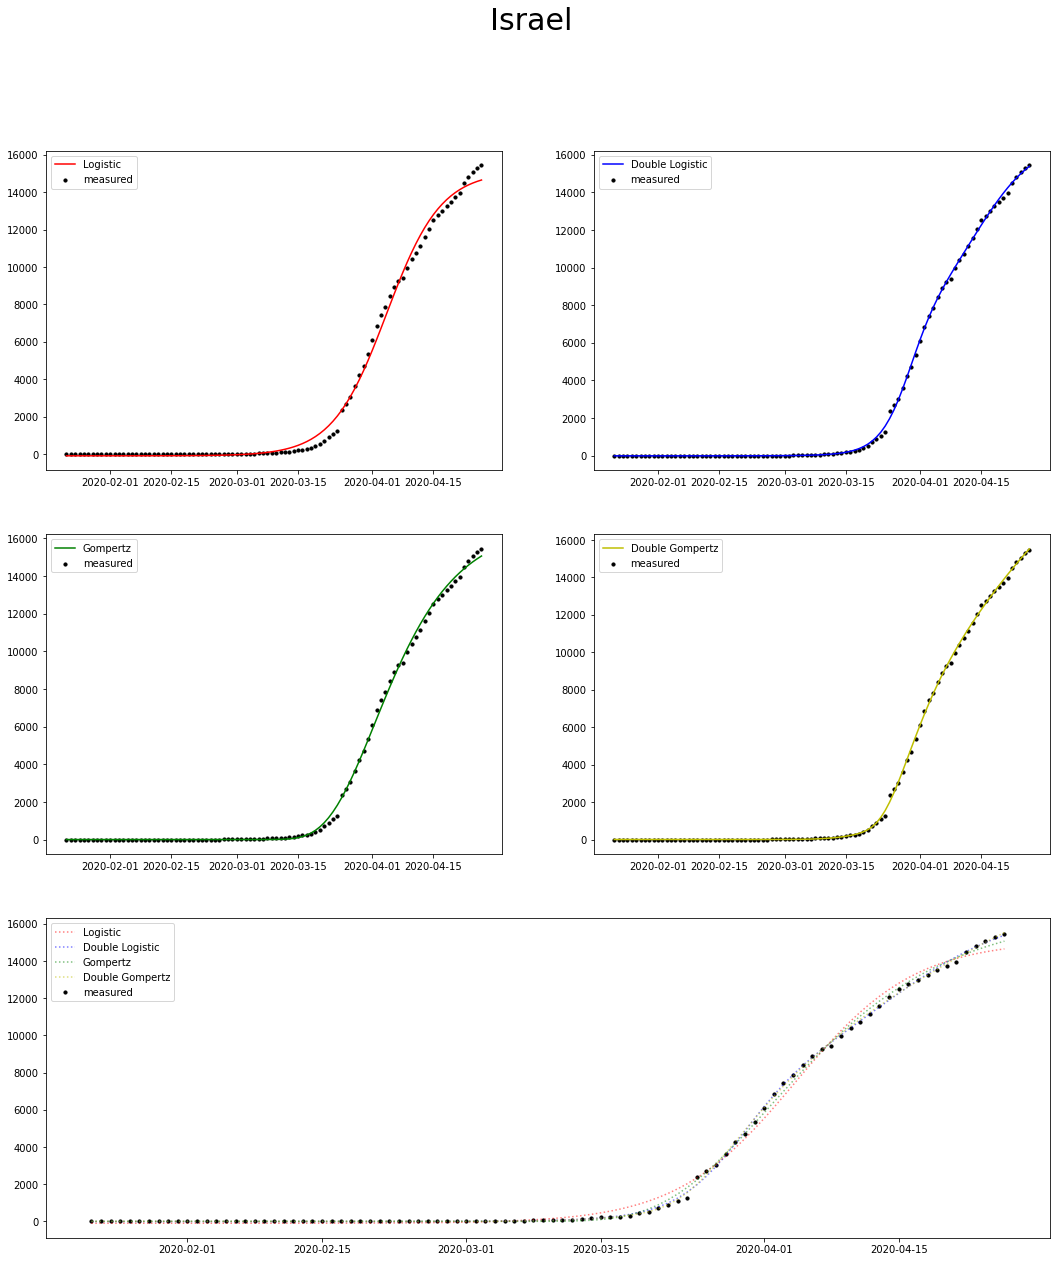

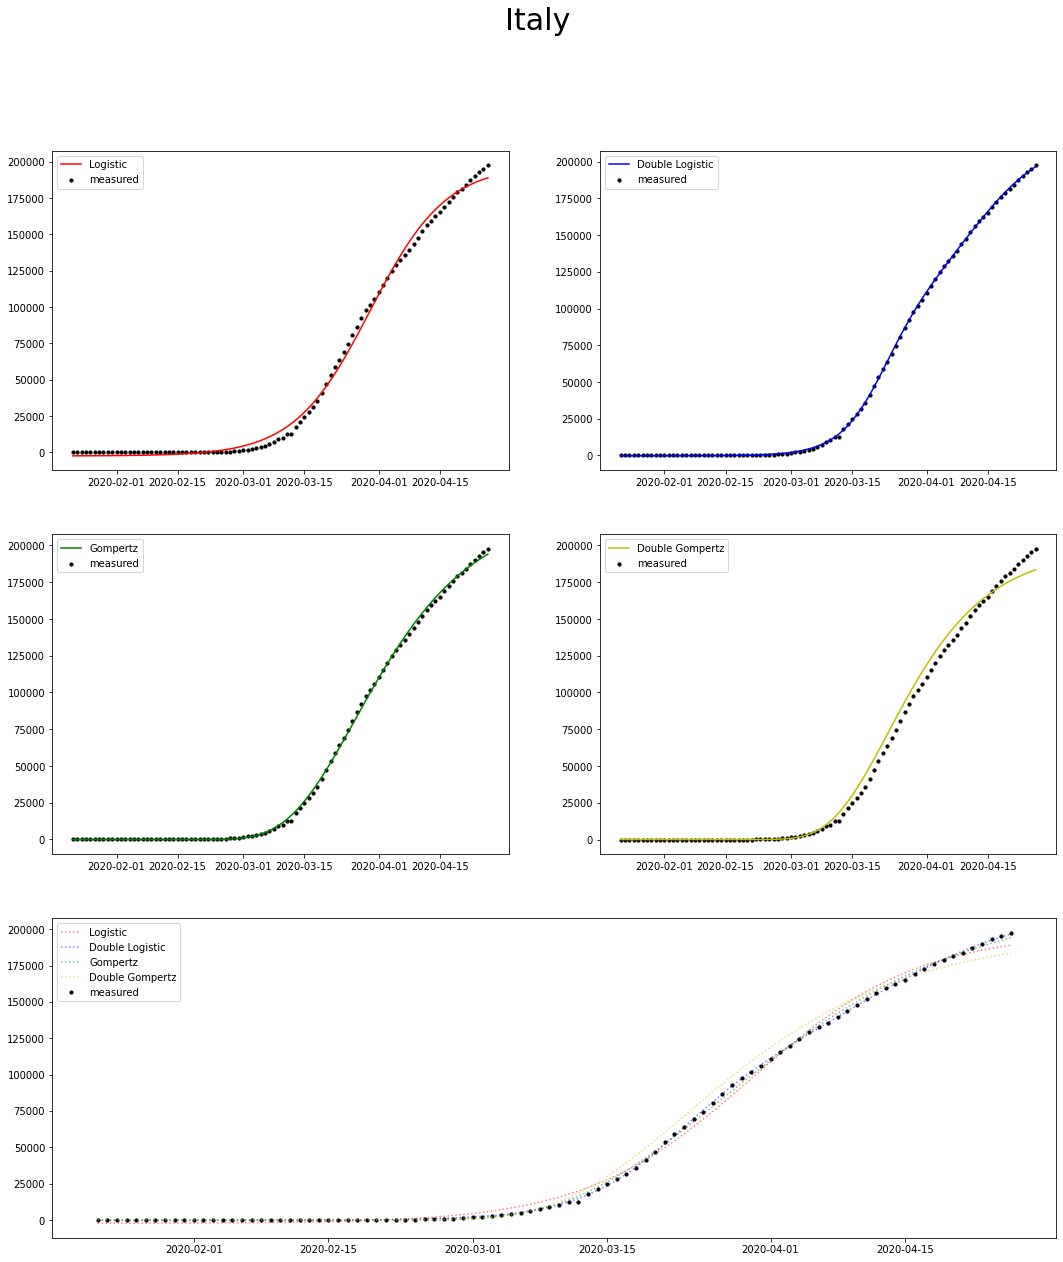

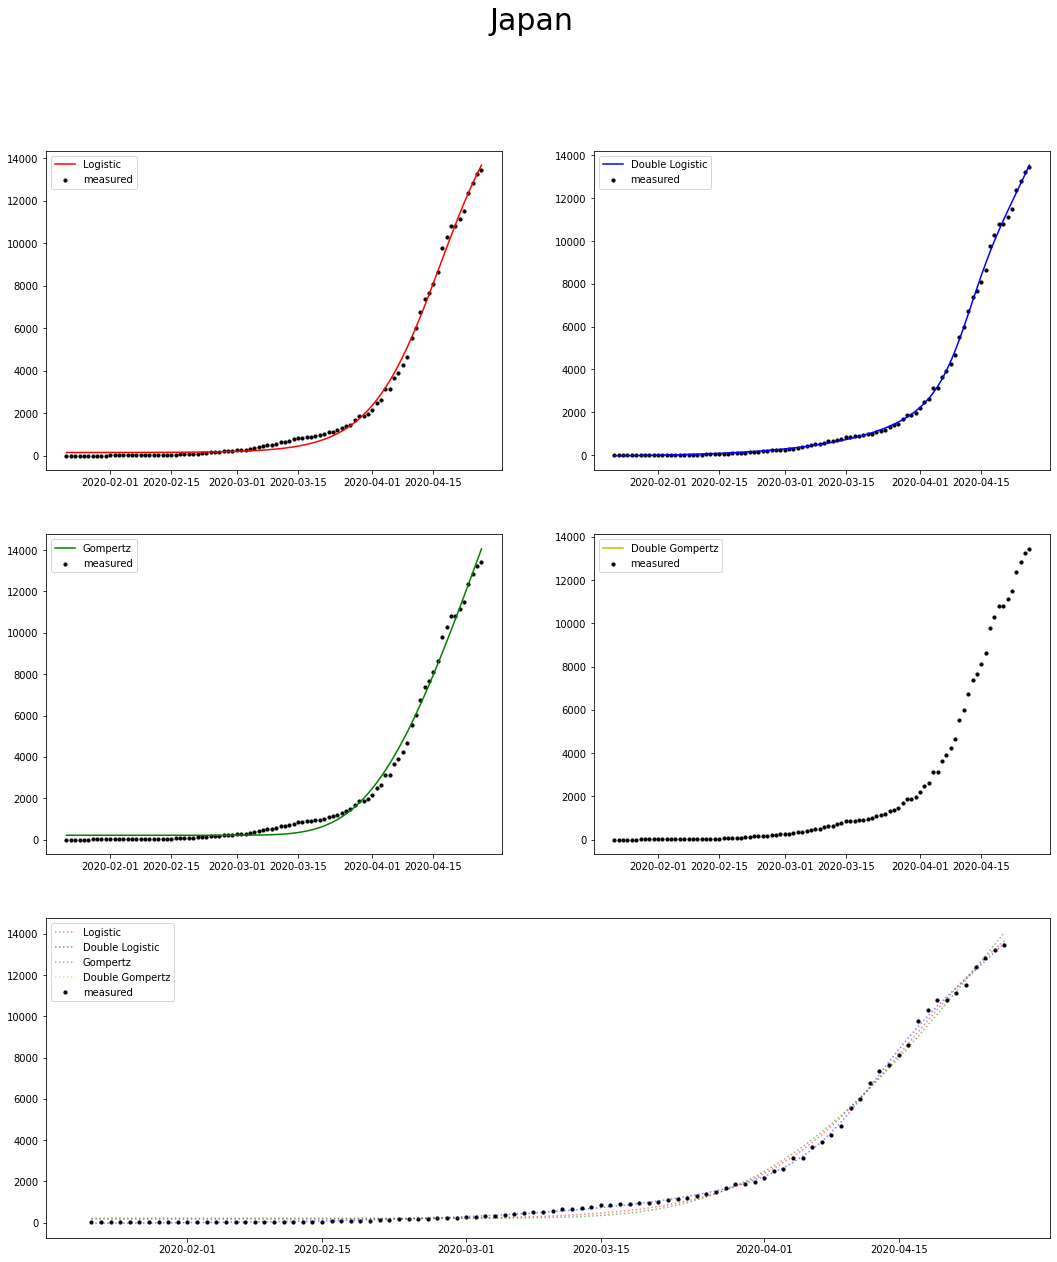

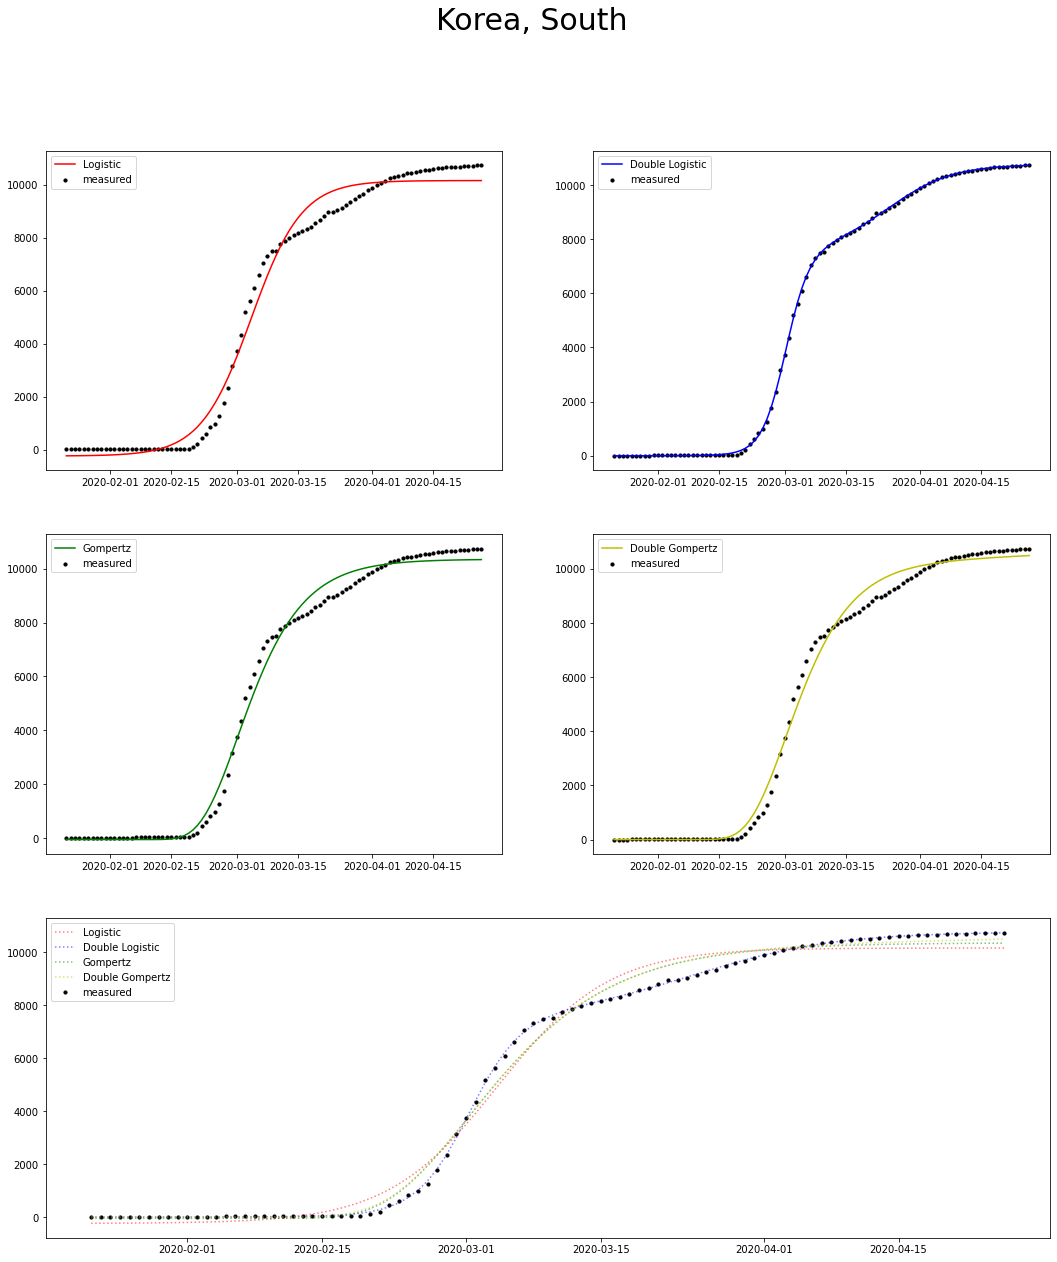

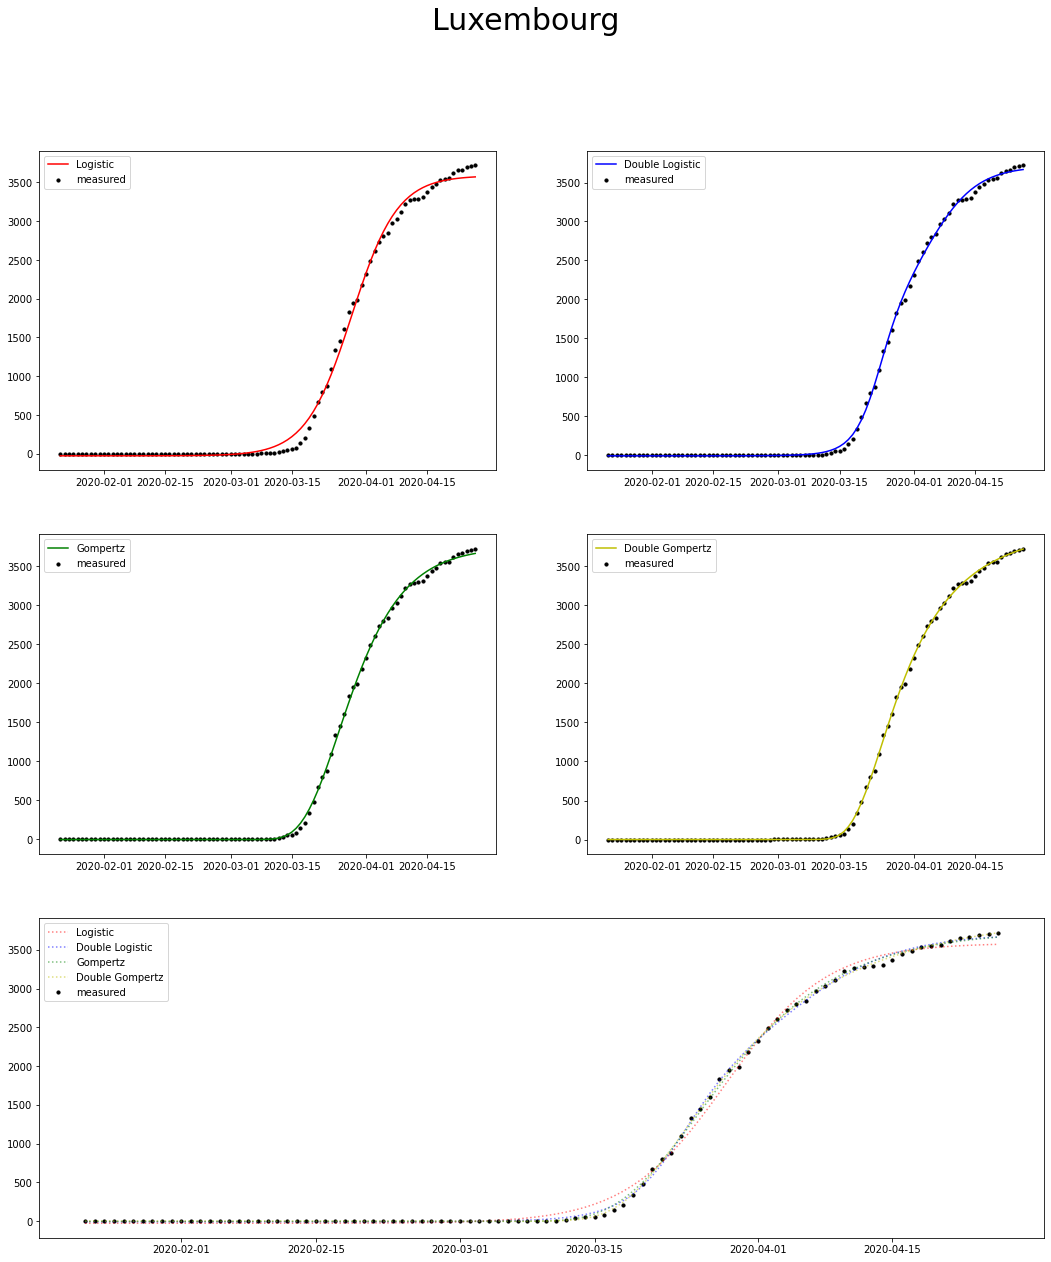

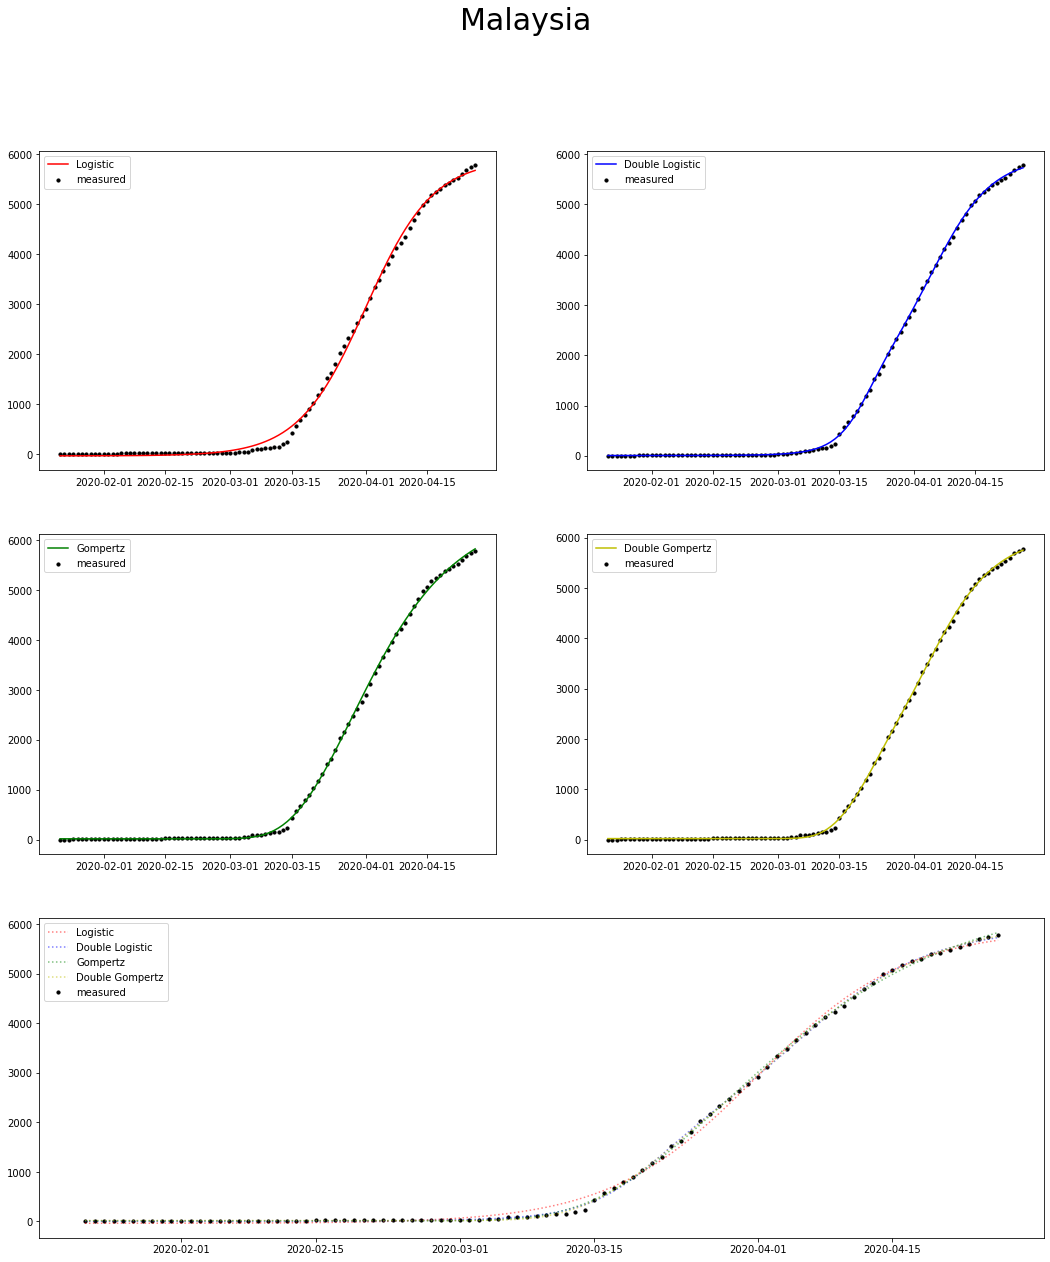

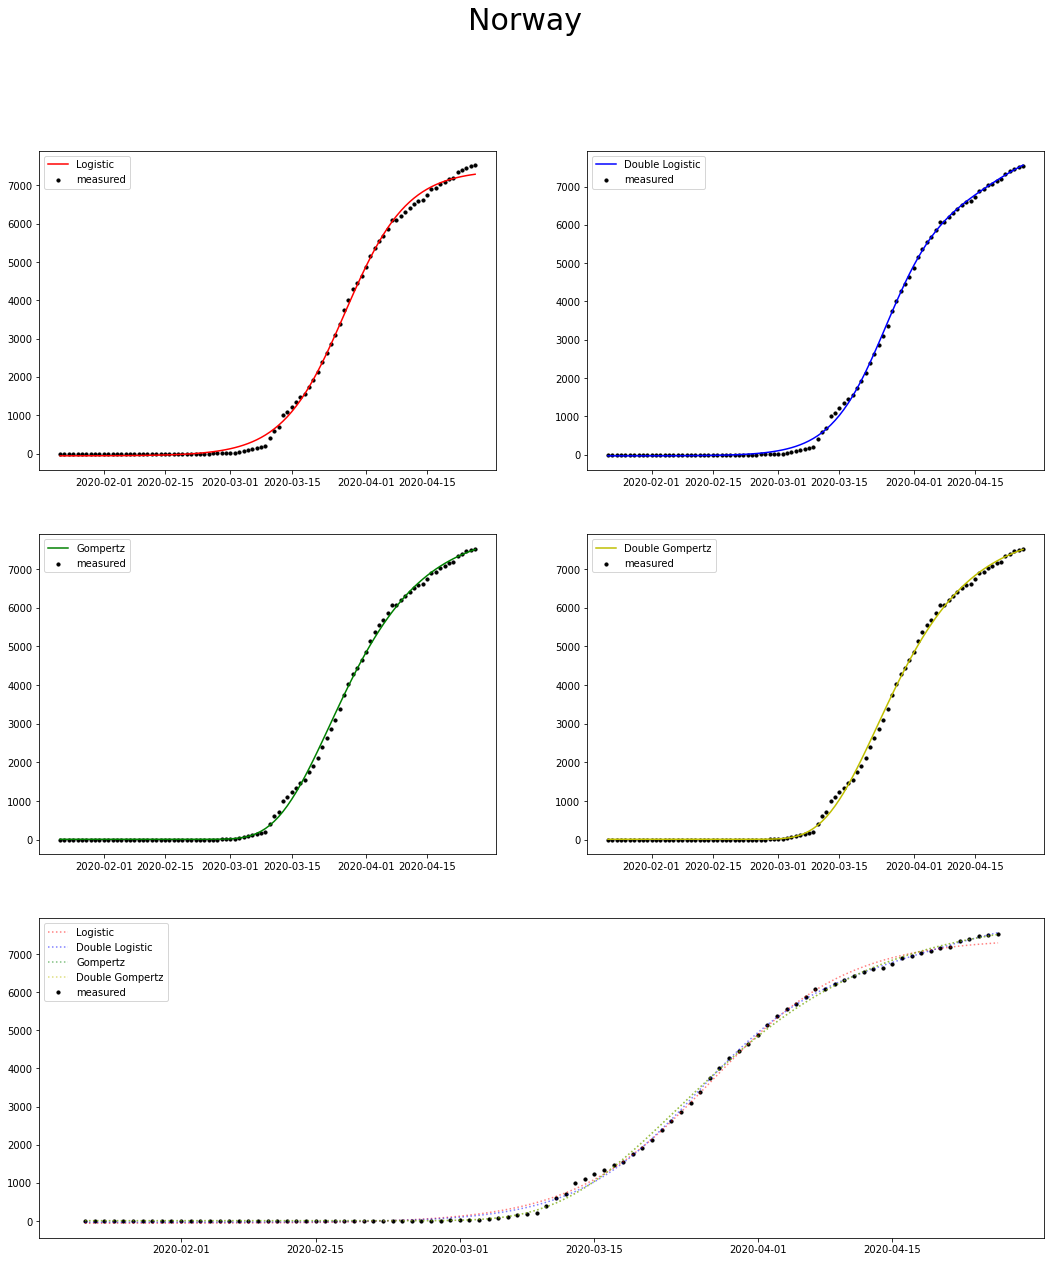

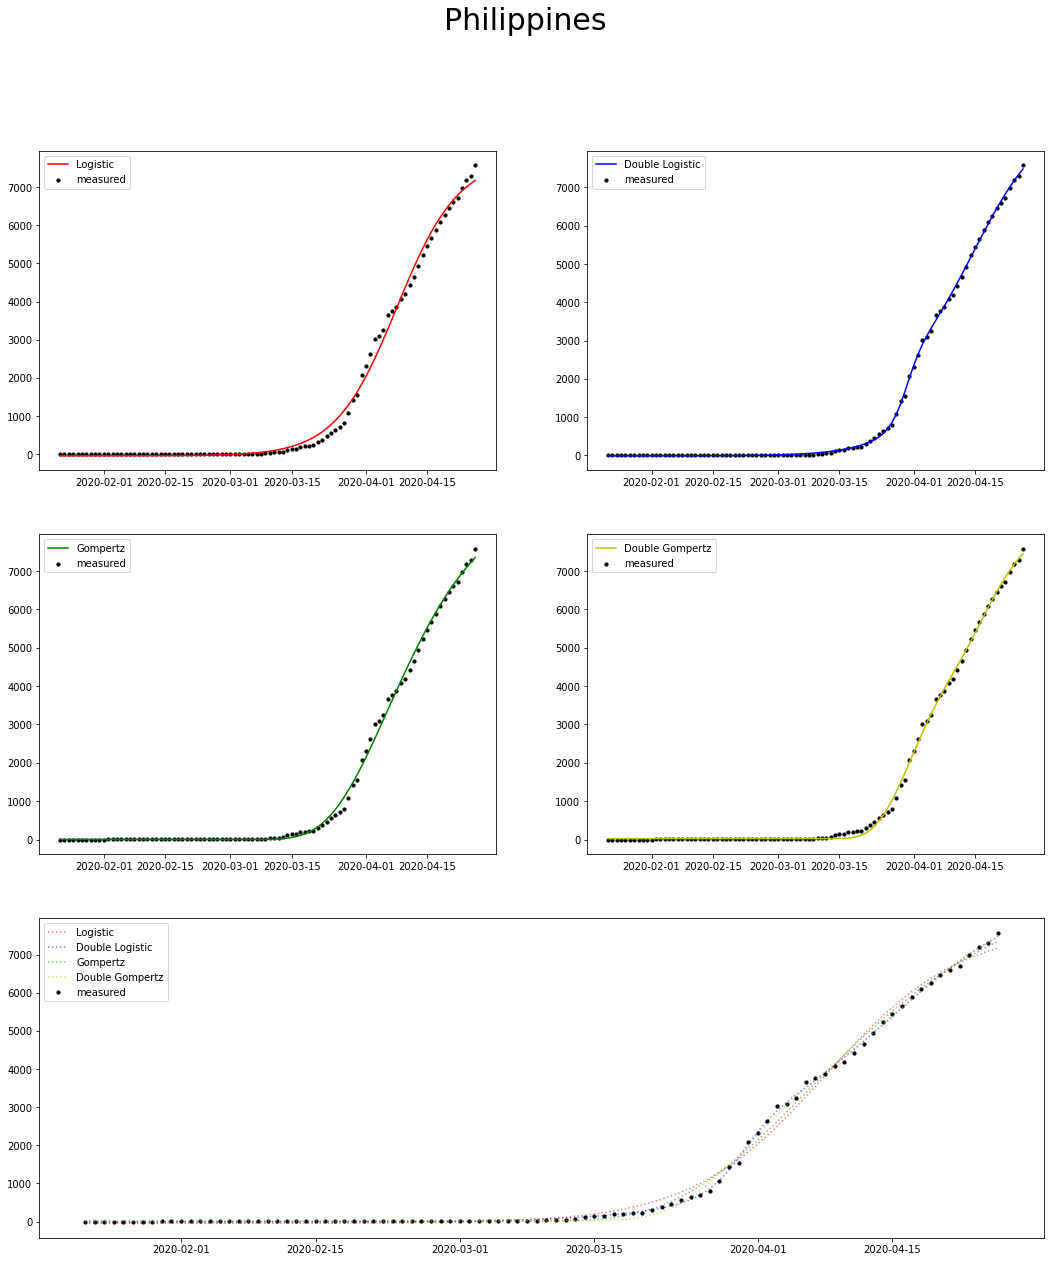

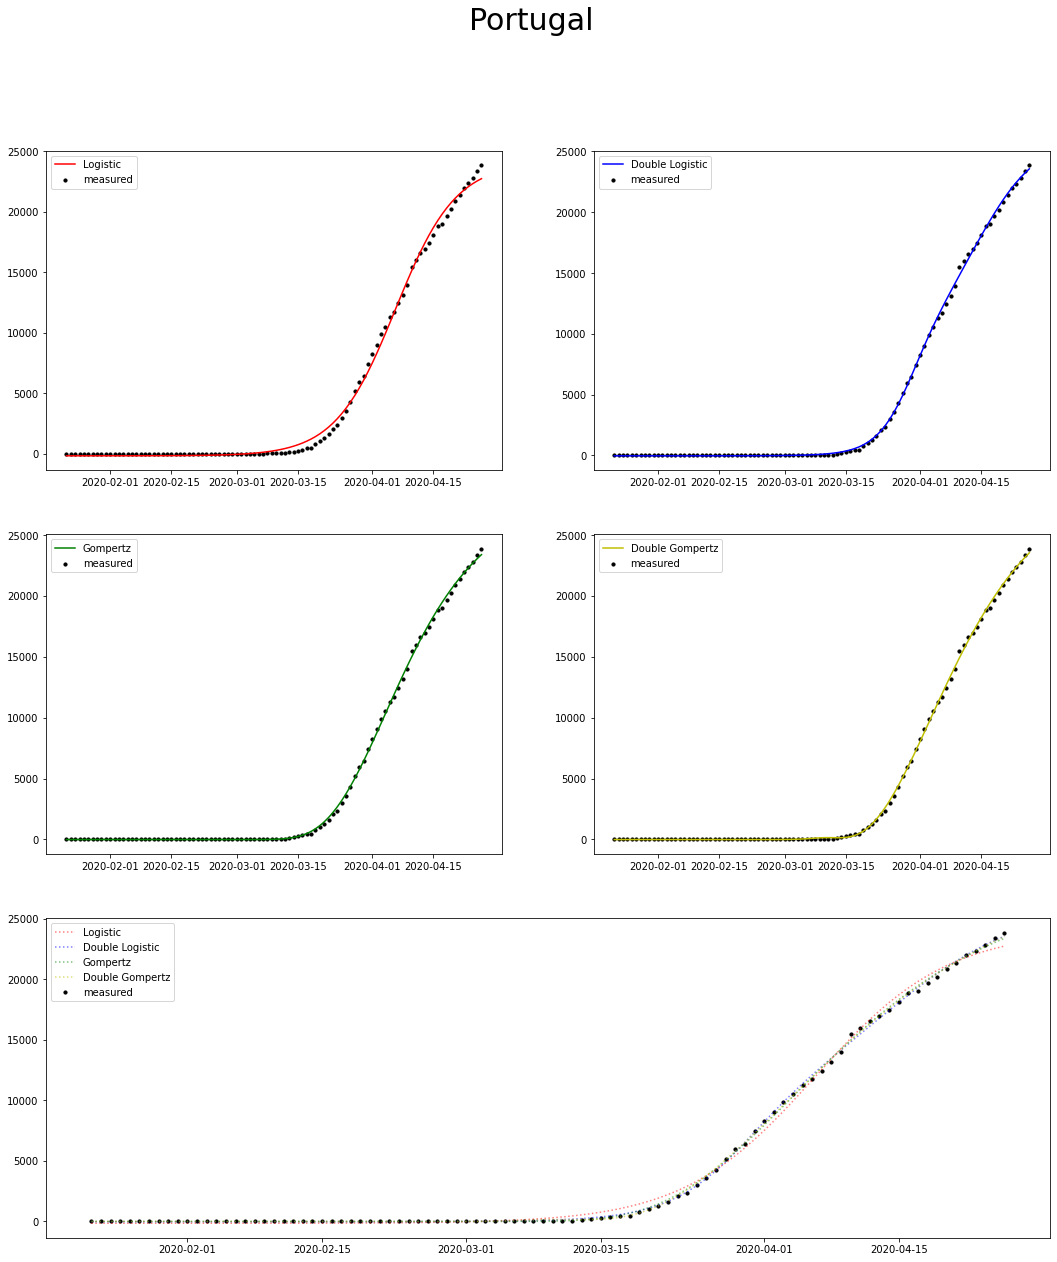

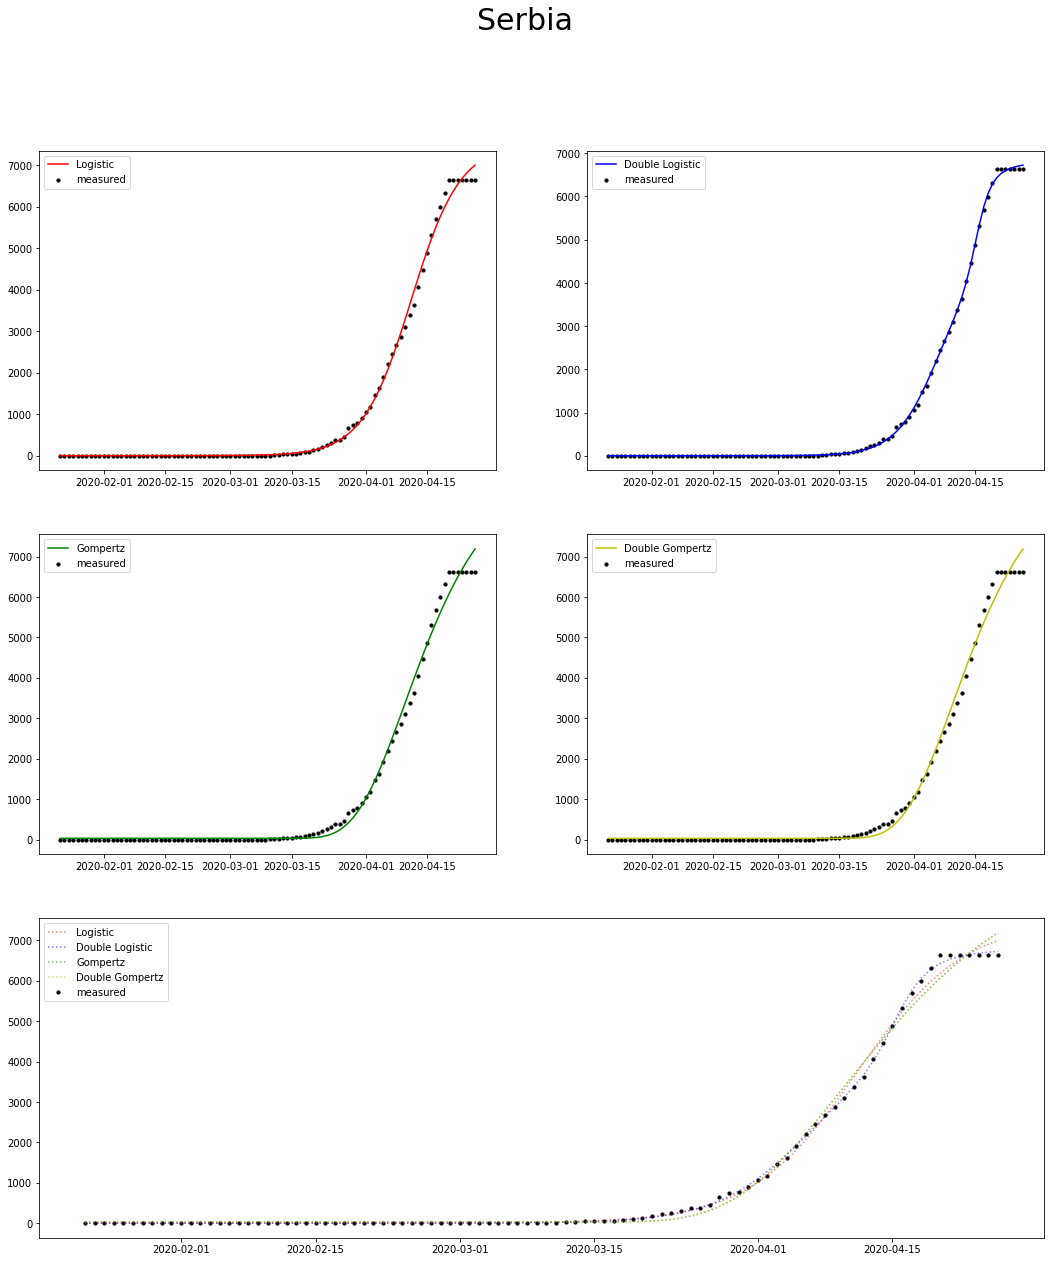

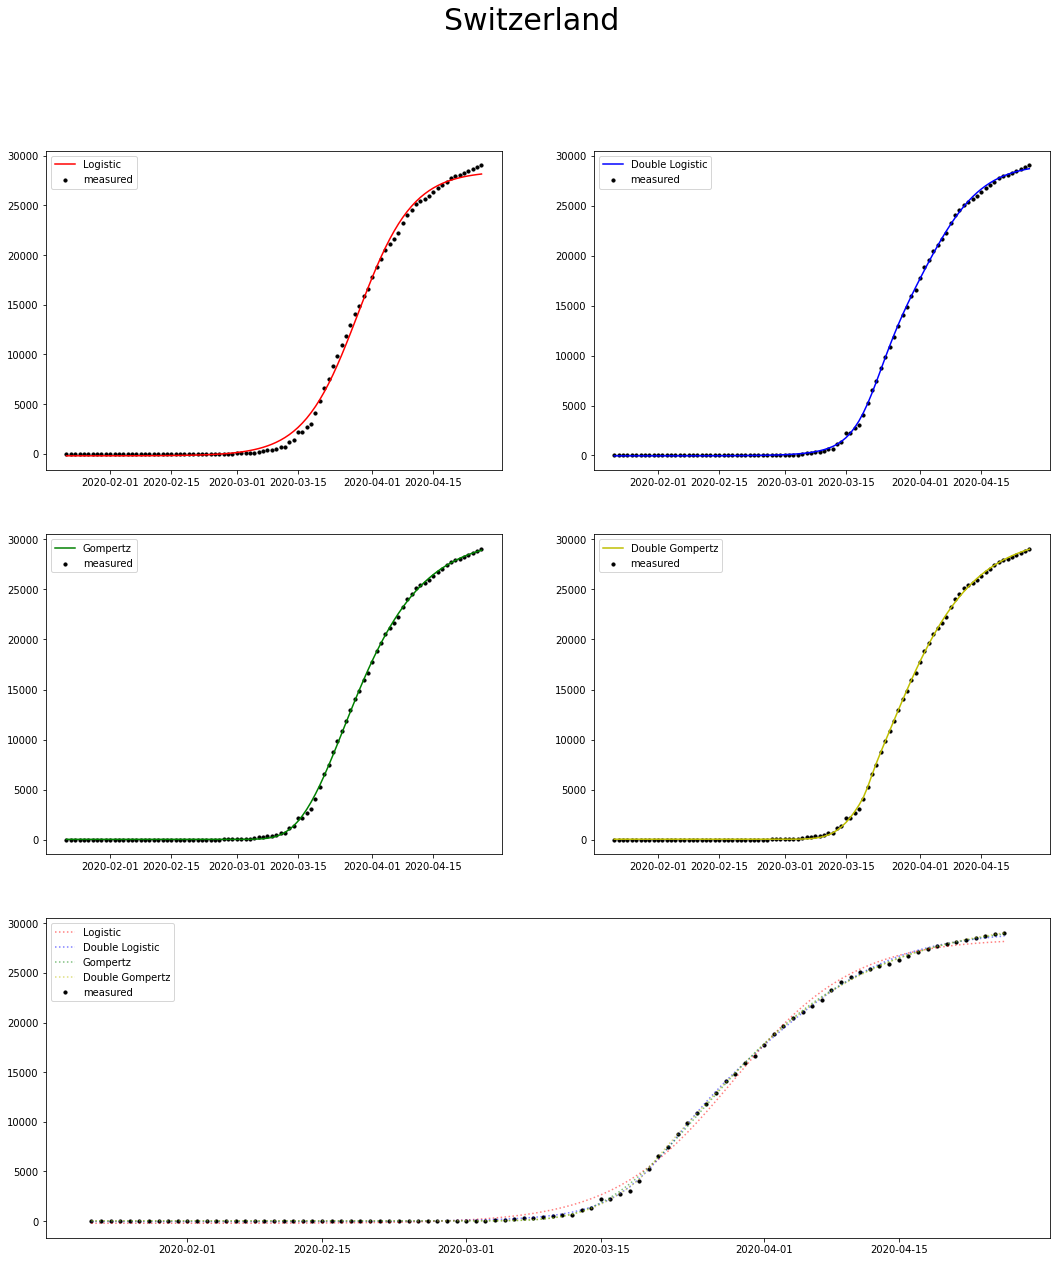

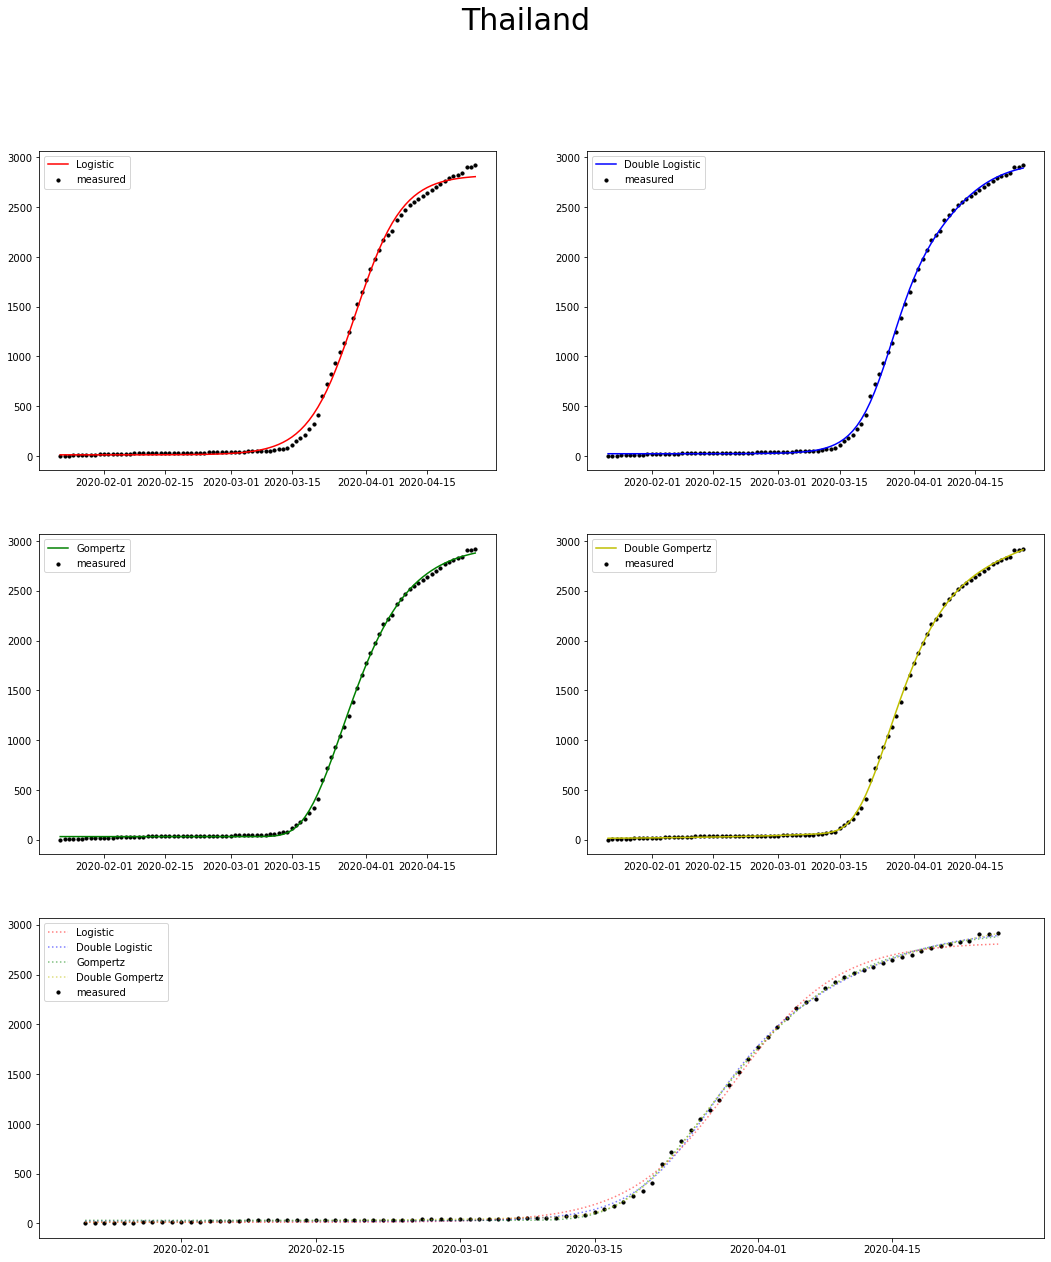

In [231]:
for c in OKs:
    plot_country(c)